In [351]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [352]:
!python -V

Python 3.10.8


In [353]:
from joblib import Parallel, delayed

In [354]:
from tqdm.notebook import tqdm

In [355]:
from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [519]:
import pyfftw

In [356]:
np.finfo(float).eps

2.220446049250313e-16

In [431]:
nx = 2000+1
nz = 1000+1
xmax = 100 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-4# Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print(dx, dz, zmax)
print(1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print(pxmax,pzmax)
print(nx*nz/1000/1000,"million grid points")
print((nx*nz)*0.001*0.001/60/60,"hours (for 1μs per operation)")

0.1 0.10004997501249374 50.02498750624687
0.07934509727772228j
1997.1515356357554 1998.1481172437757
2.003001 million grid points
0.0005563891666666667 hours (for 1μs per operation)


In [432]:
wavelength = 1.083 #Micrometers
# k = (1/sqrt(2)) * 2*pi / wavelength
k = 0.2*2*pi / wavelength
p = hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

k = 1.1603296966167287 1/µm
p = 73.68998630679589 u*µm/ms
v = 18.422496576698972 µm/ms


In [433]:
a4 = 0.007512
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggCenter = 1
tBraggPi = np.sqrt(2*pi*hb)/V0
print(V0)
print(tBraggPi*1000,"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


1270.156
15.727018740679478 µs


In [434]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max size of this thing")

1.5746097329776815e-06j term infront of Bragg potential
0.050733363643743784j max size of this thing


In [435]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
print(psi.nbytes/1000/1000, "MB of data used")


zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

32.048016 MB of data used


In [436]:
# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

##### Checking parameters reasonable

In [437]:
V0

1270.156

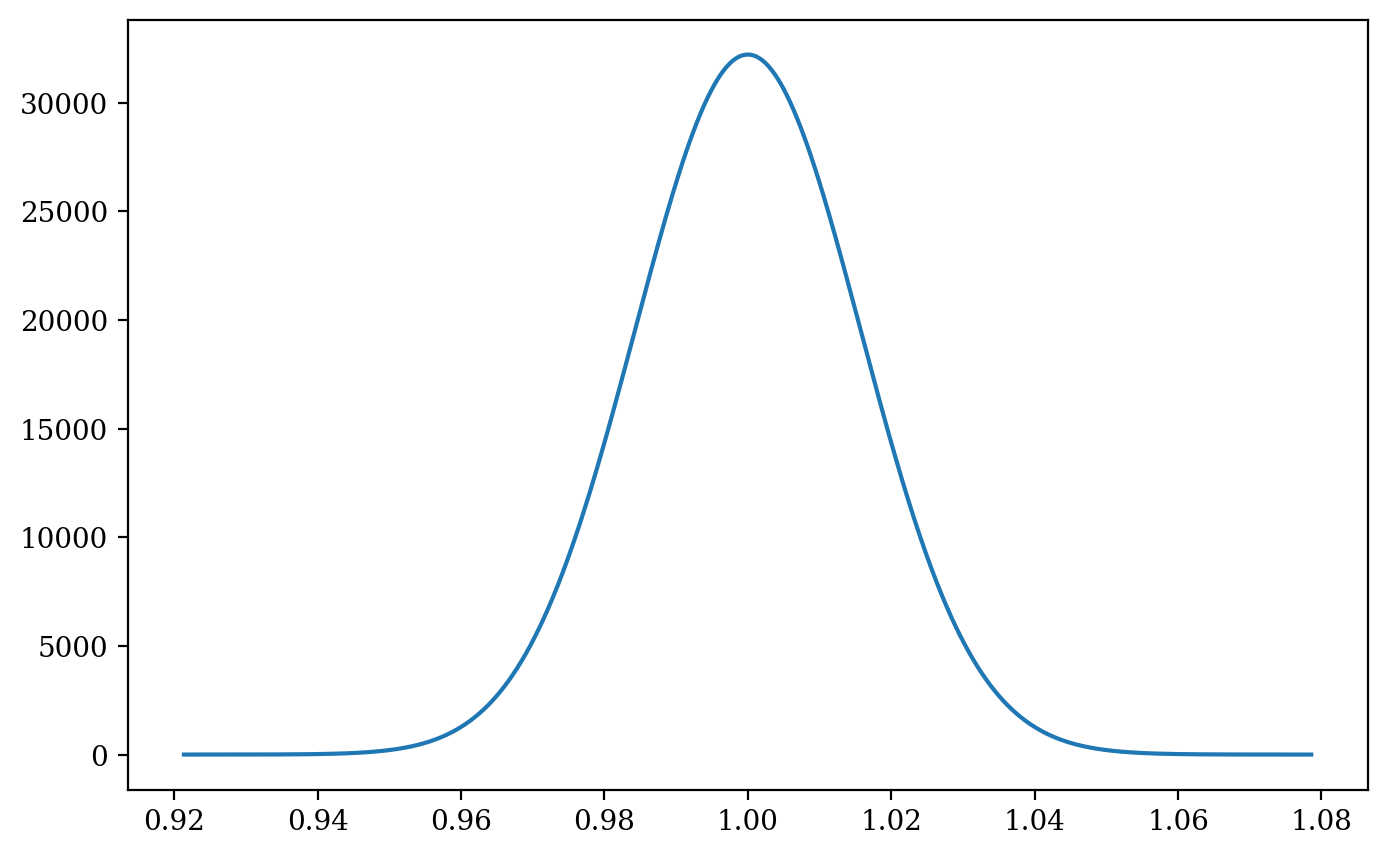

In [438]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [439]:
np.trapz(V(tbtest),tbtest)

1270.1552632290575

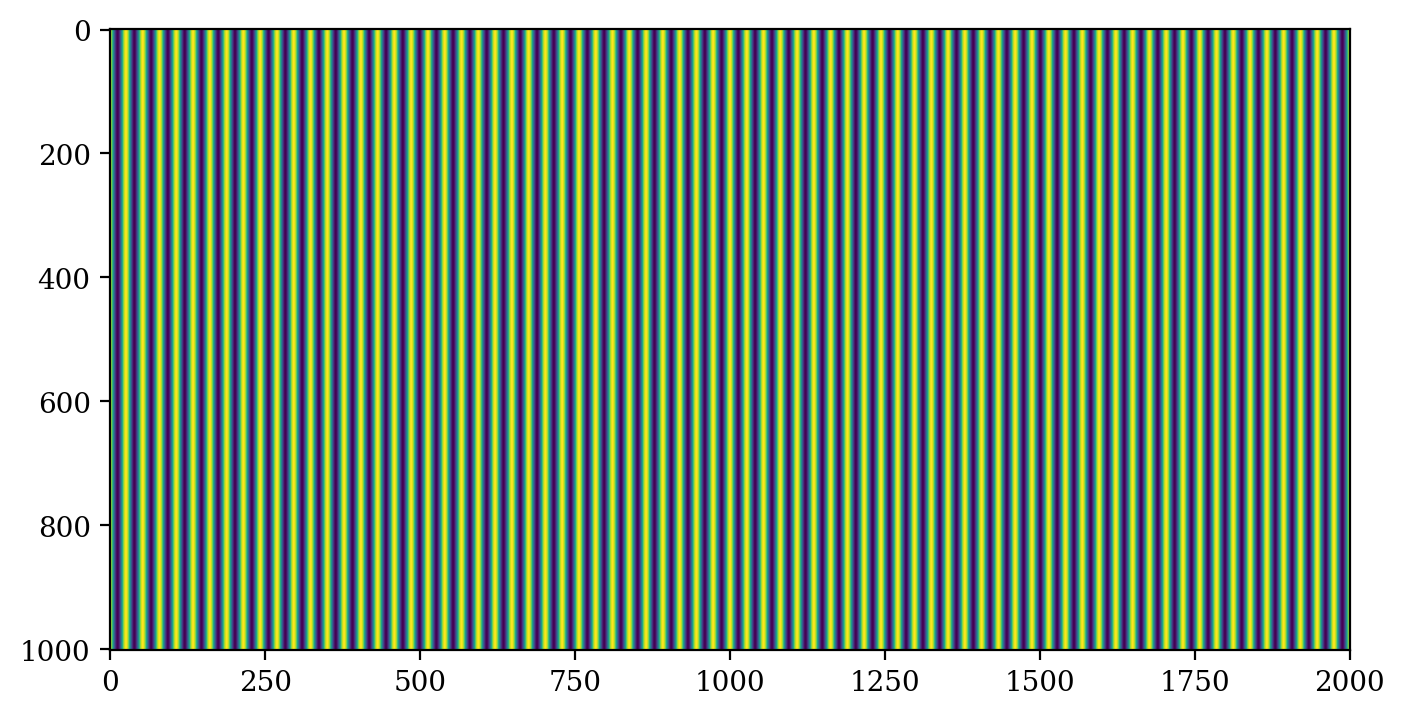

In [440]:
# vtest = np.cos(2*k*xlin)
plt.imshow(cosGrid.T)
plt.show()

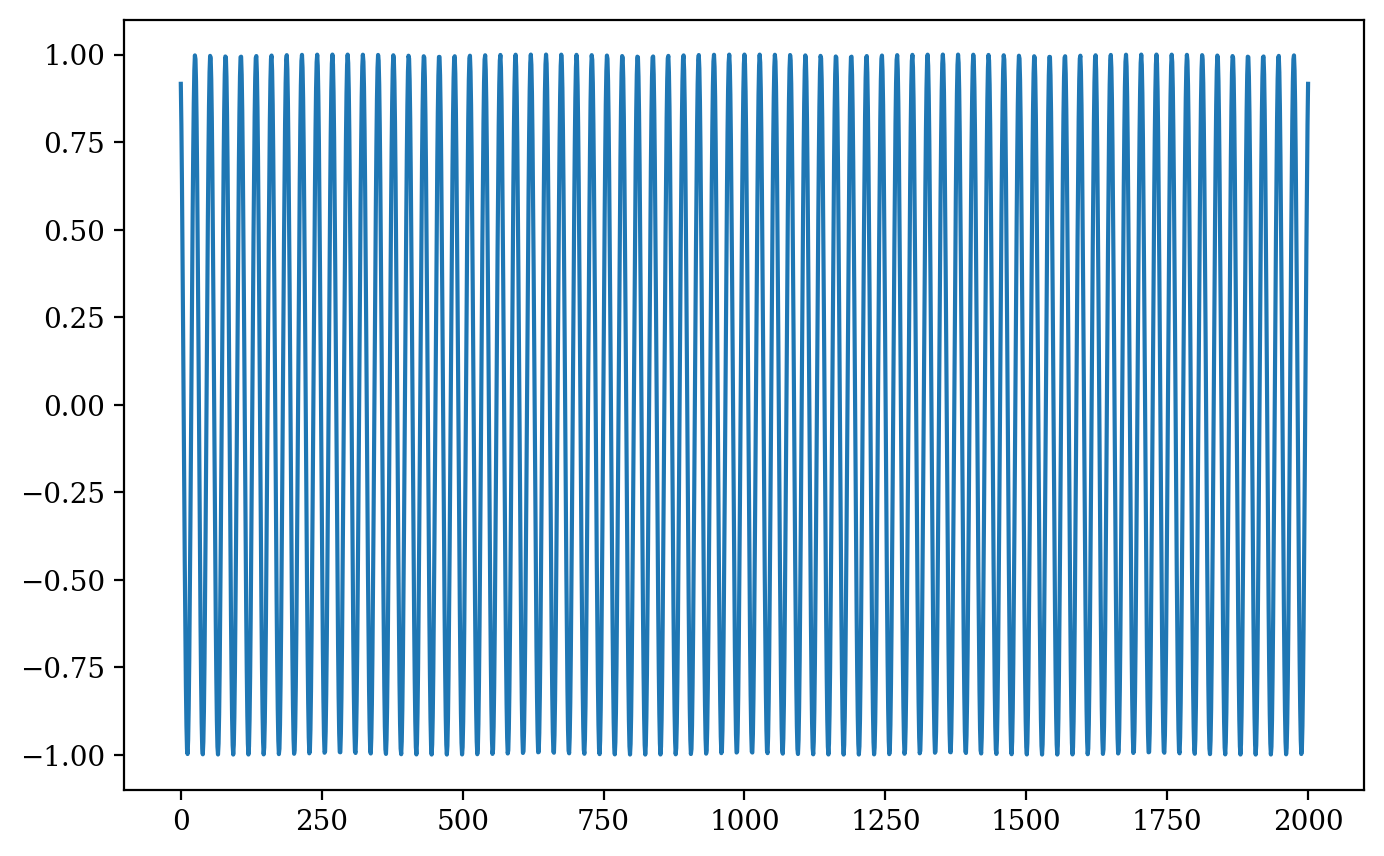

In [441]:
plt.plot(cosGrid[:,0])

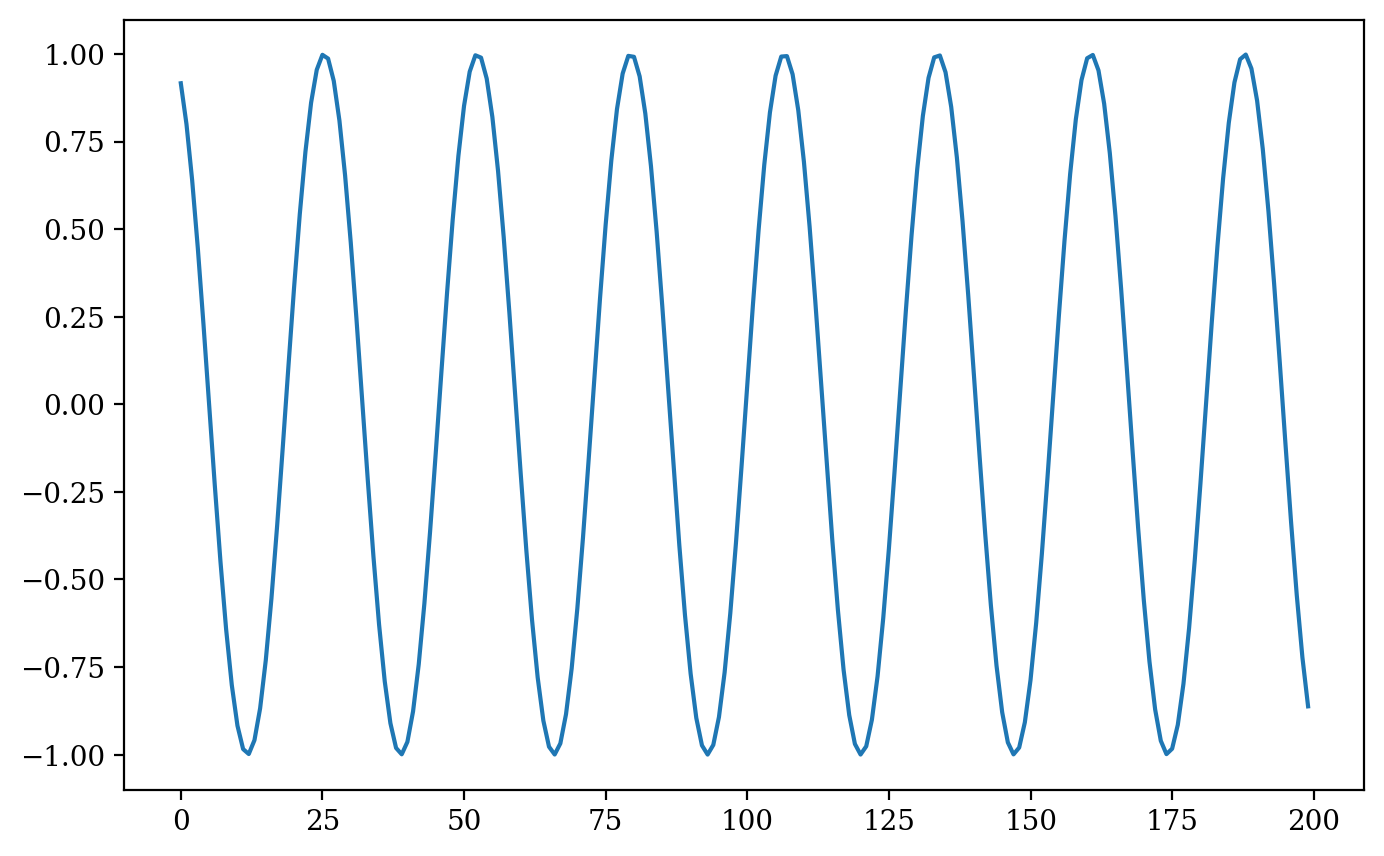

In [442]:
plt.plot(cosGrid[:200,0])

#### Initial State

In [443]:
def plot_psi(psi):
    plt.figure(figsize=(12,6))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])*0.001
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (mm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [444]:
def plot_mom(psi):
    plt.figure(figsize=(3,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])
    psifft = np.fft.fftshift(np.fft.fft2(psi))
#     plotdata = ((np.abs(psifft)**2).T)[:,::-1] # weird flipping????
#     plotdata = ((np.abs(psifft)**2).T) # weird flipping????
    plotdata = np.flipud((np.abs(psifft)**2).T)
    plt.imshow(plotdata,extent=extent)
    plt.show()

In [445]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))

0.9999999999999996 normalisation check


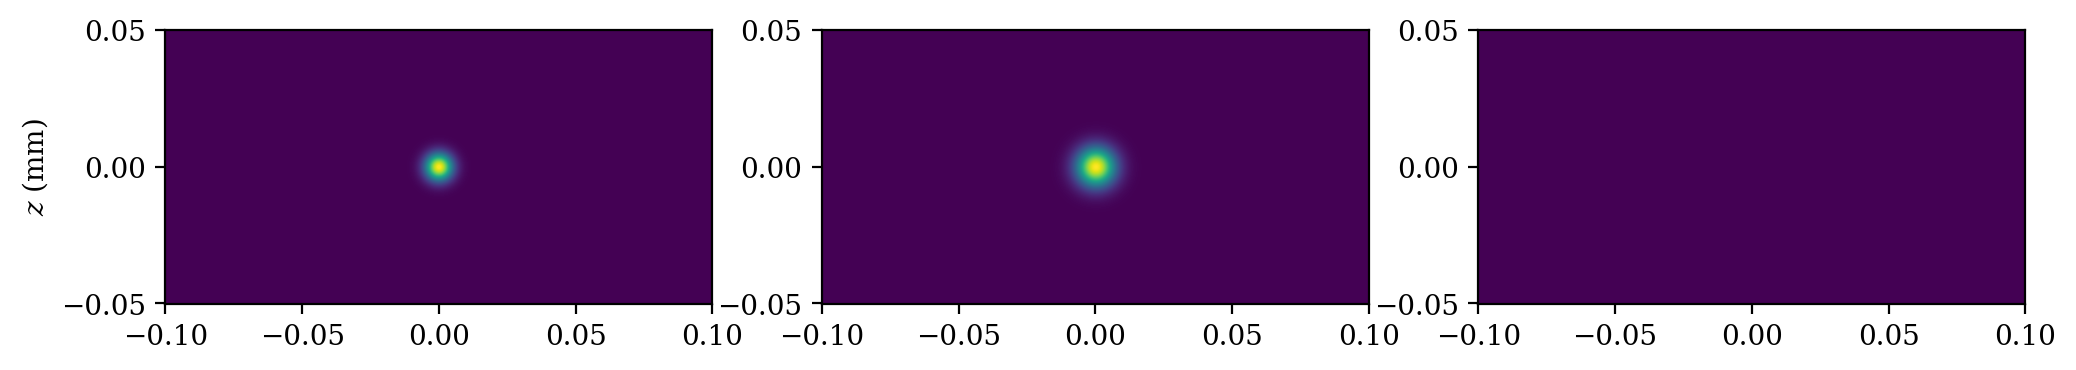

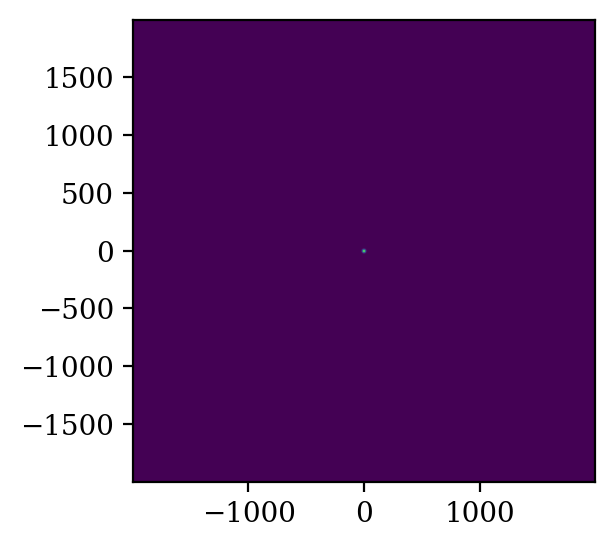

In [511]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
psi = psi0np(5,5,0,0)
t = 0

print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin), "normalisation check")
plot_psi(psi)
plot_mom(psi)

In [512]:
V00 = 10000
# dt=0.01
VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
        

In [515]:
# @njit(parallel=True)
for step in range(150):
    psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(np.fft.fft2(psi)))
    phi *= expPGrid
    psi = np.fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
    psi *= VxExpGrid
    t += dt
#     if step % 20 == 0:
#         print("time =", round(t*1000,4), "µs")
#         print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
#         plot_psi(psi)
#         plot_mom(psi)

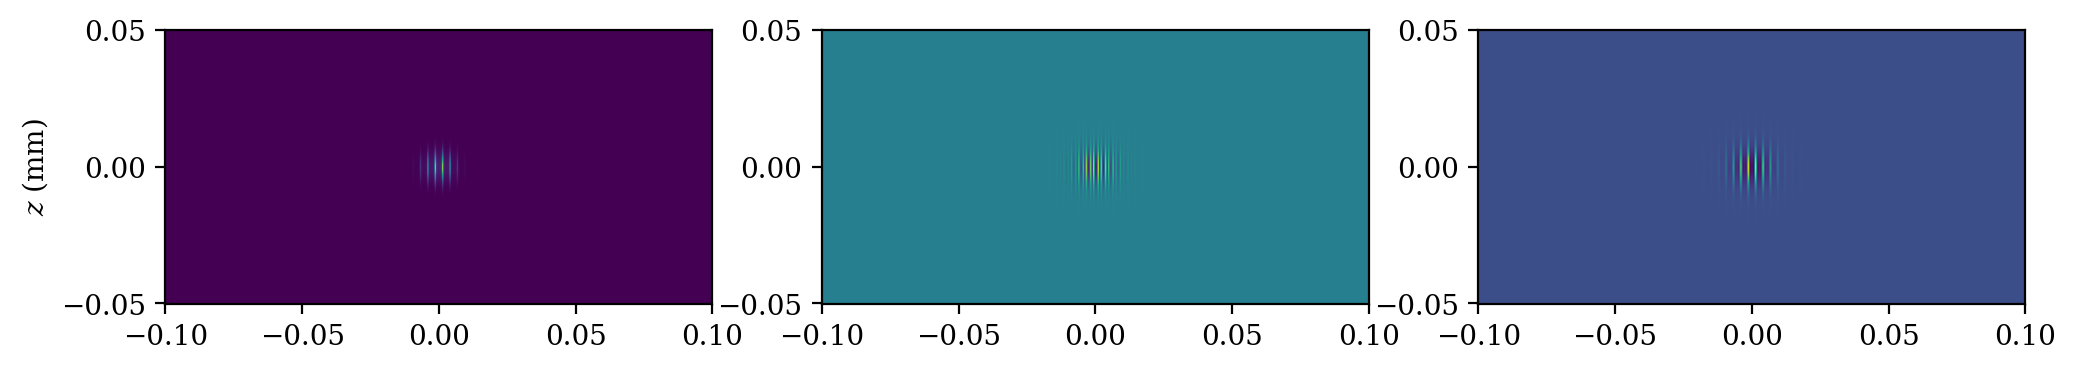

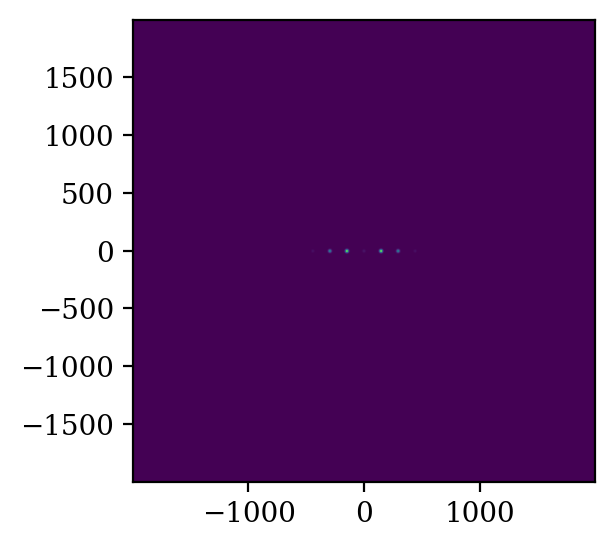

In [516]:
plot_psi(psi)
plot_mom(psi)

time = 15.1 µs
0.9999999999999725 |psi|^2


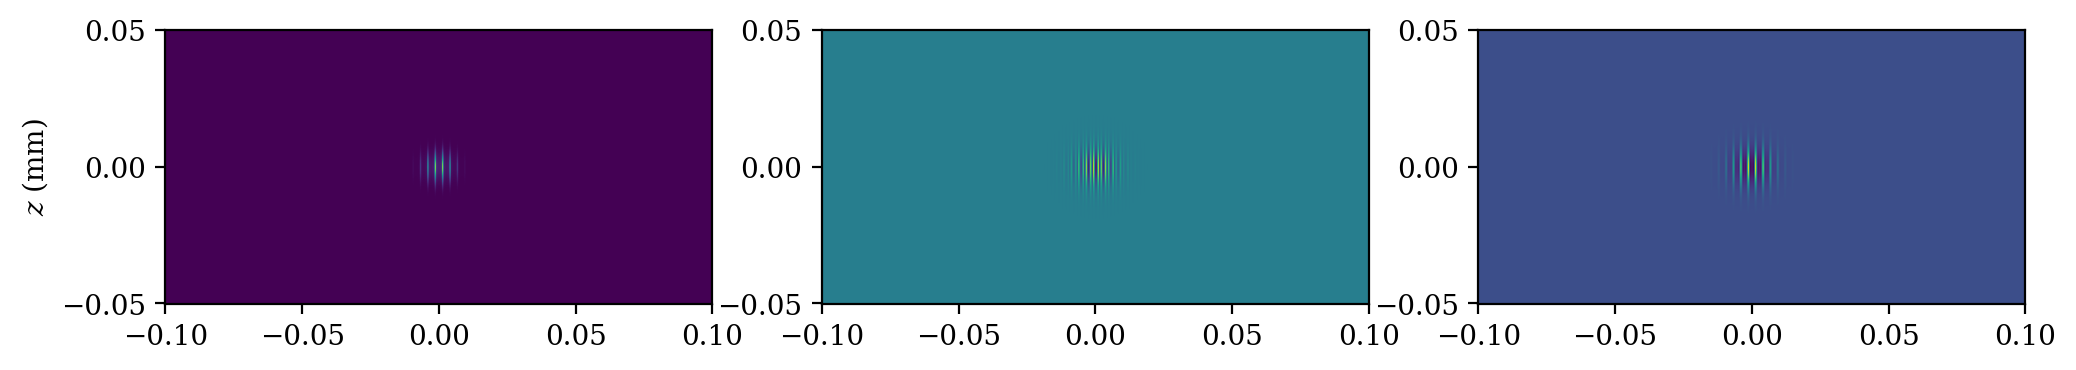

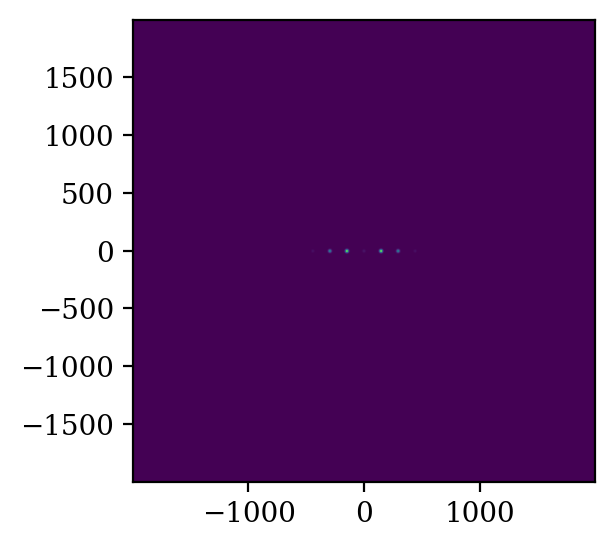

time = 35.1 µs
0.9999999999999244 |psi|^2


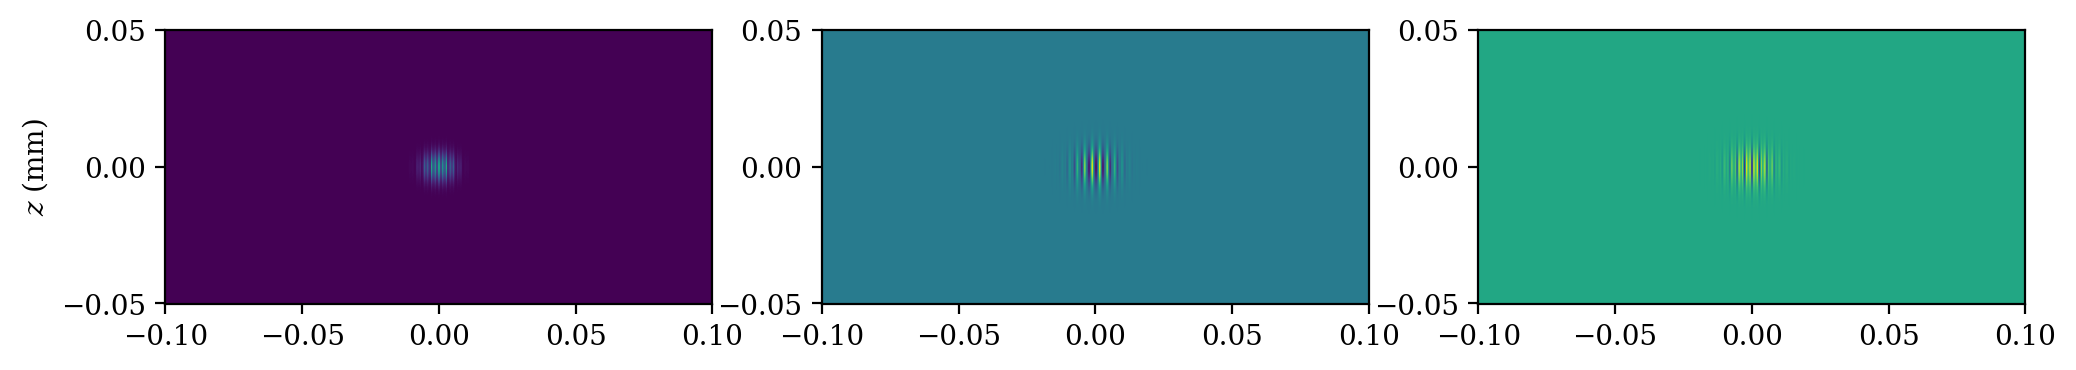

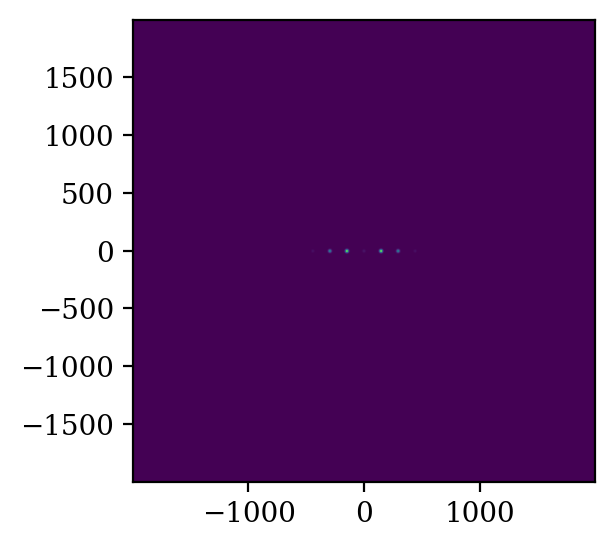

time = 55.1 µs
0.9999999999998792 |psi|^2


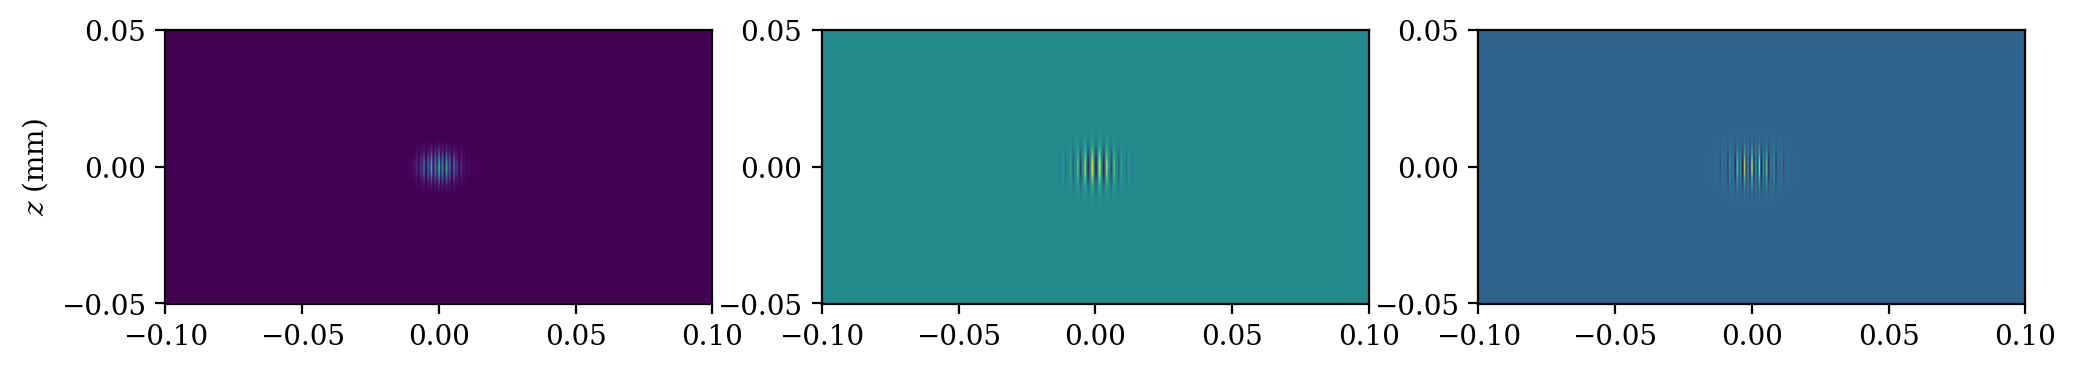

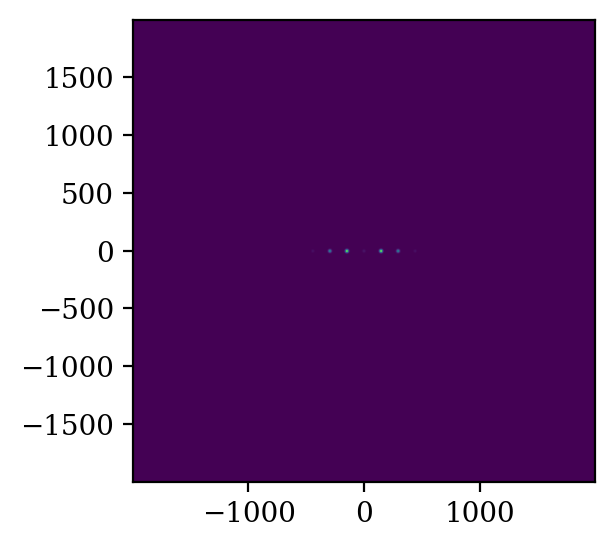

time = 75.1 µs
0.9999999999998332 |psi|^2


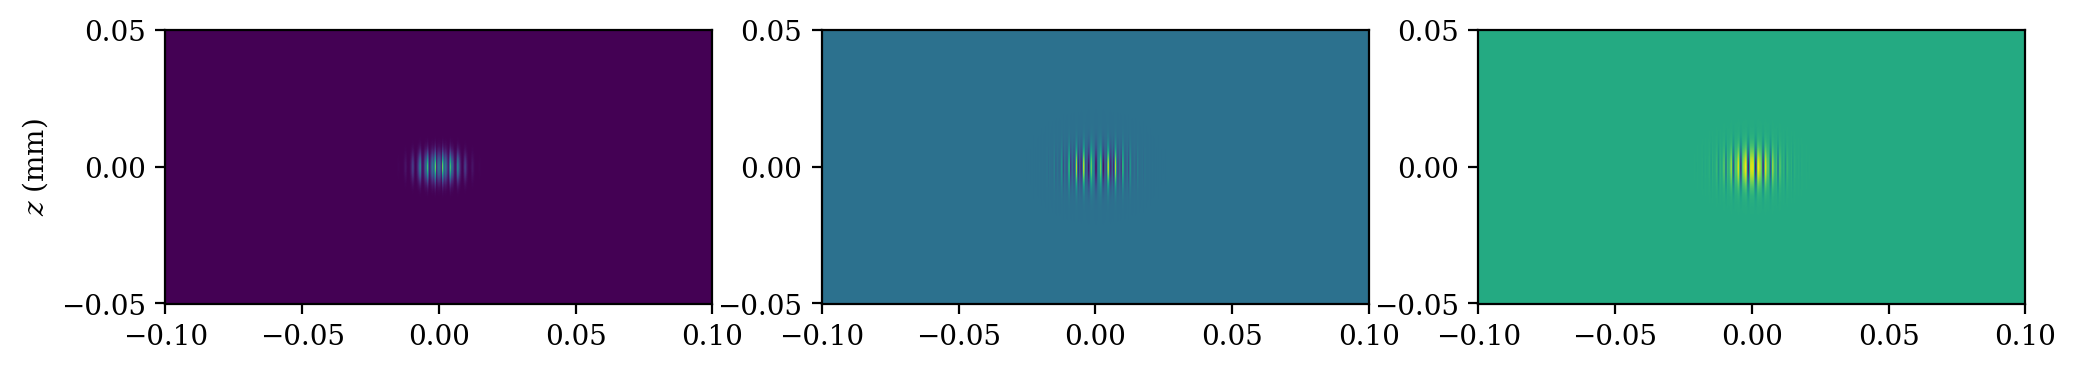

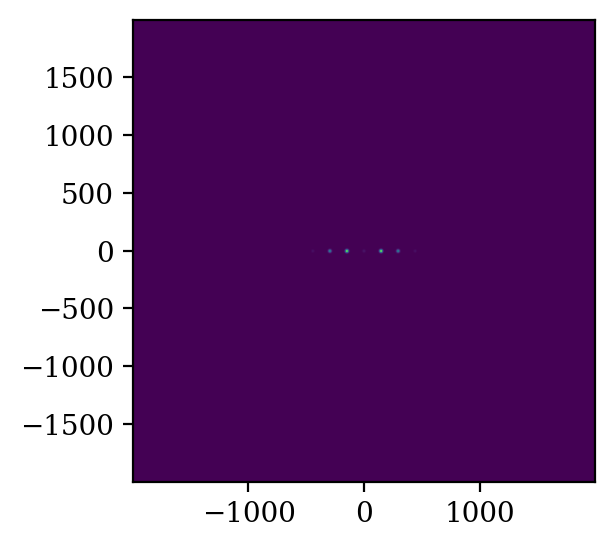

time = 95.1 µs
0.9999999999997871 |psi|^2


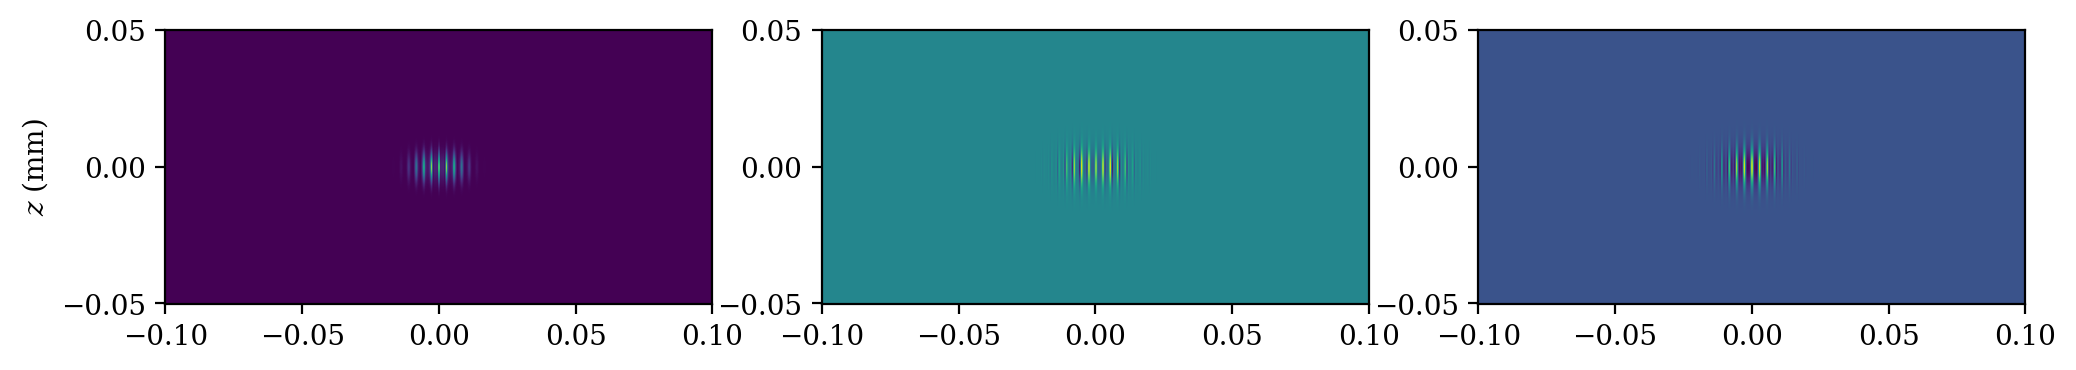

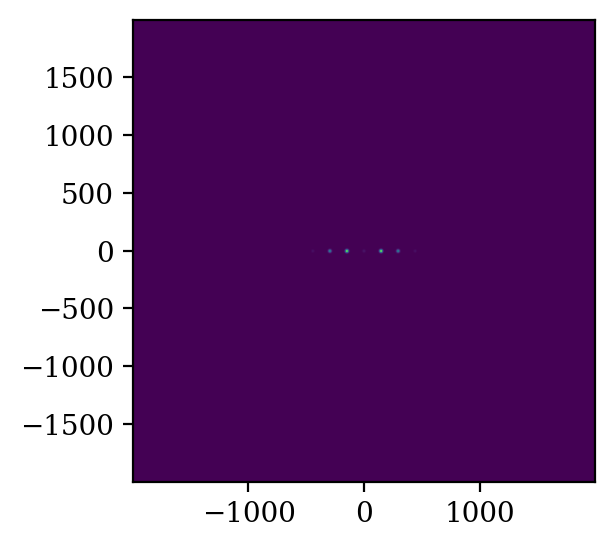

time = 115.1 µs
0.9999999999997424 |psi|^2


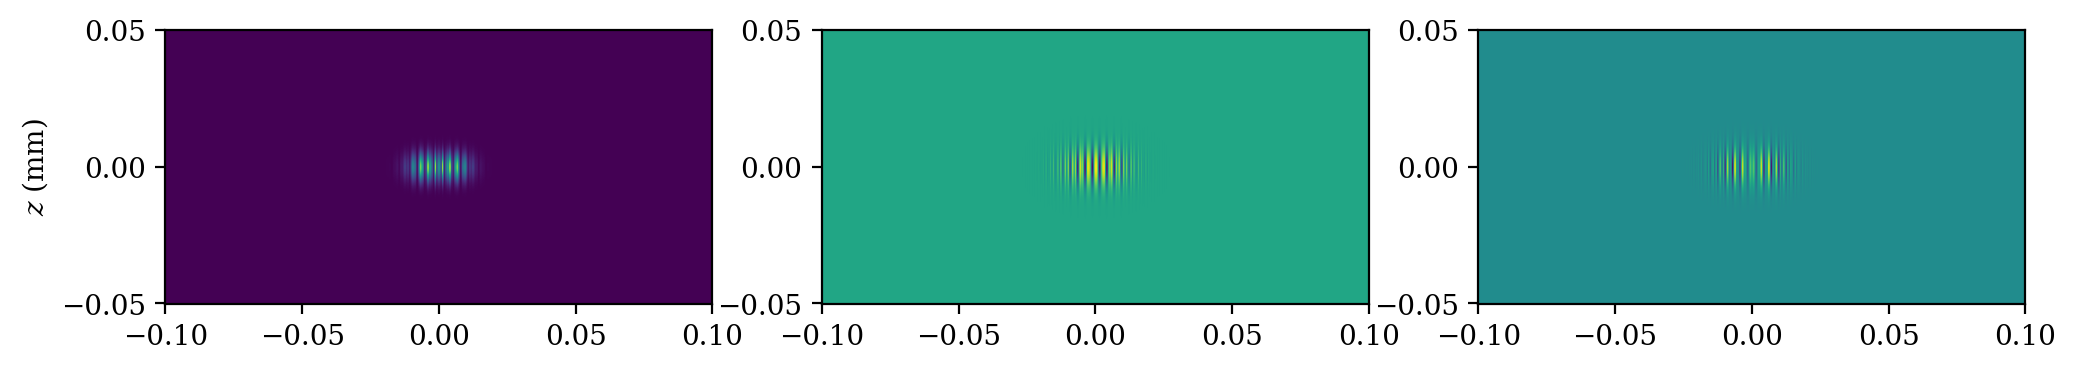

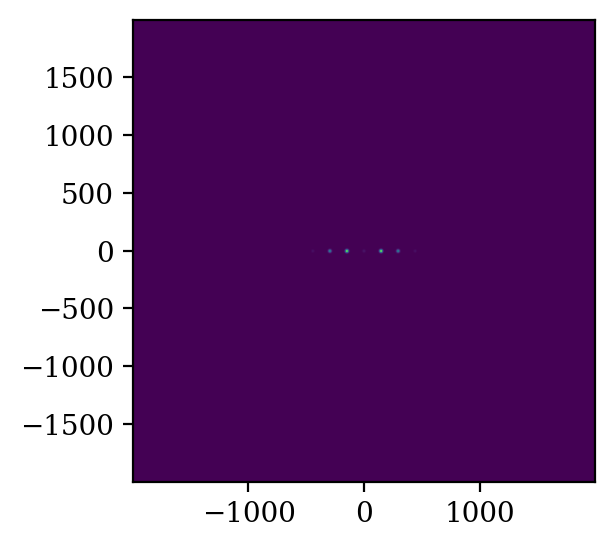

time = 135.1 µs
0.9999999999996957 |psi|^2


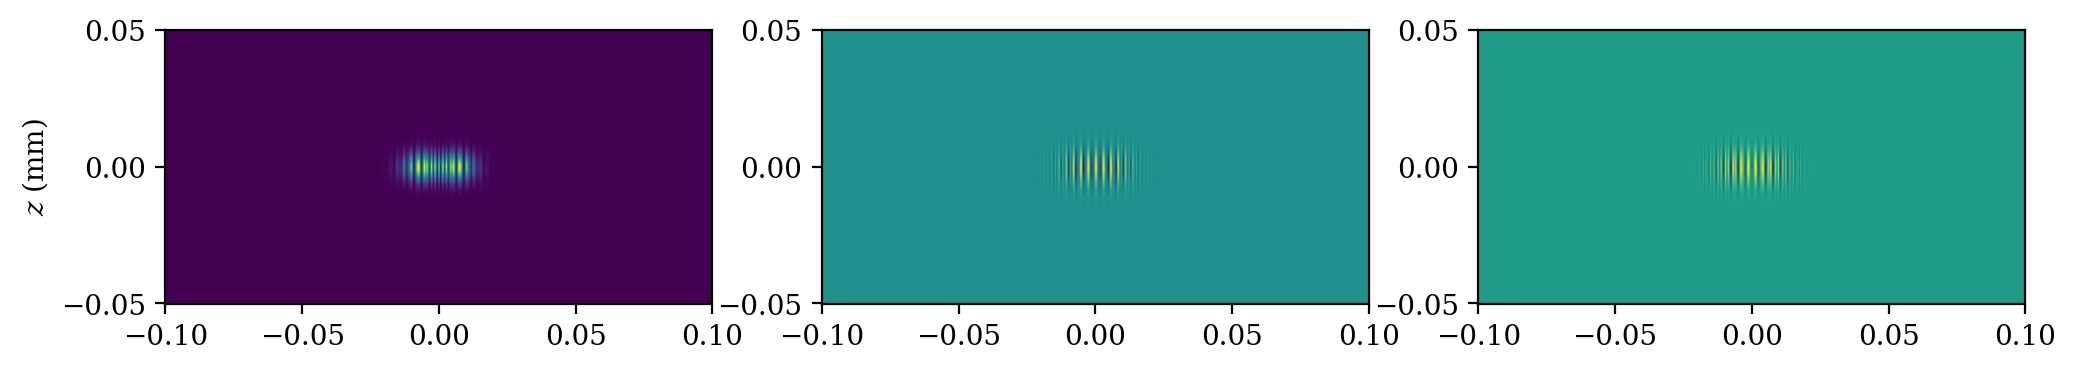

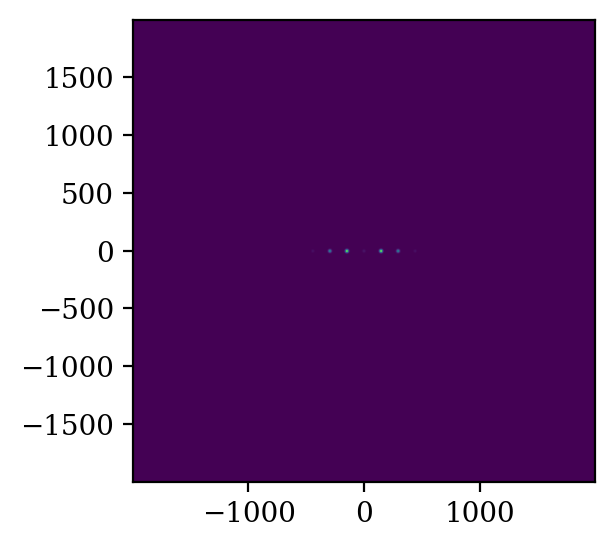

time = 155.1 µs
0.99999999999965 |psi|^2


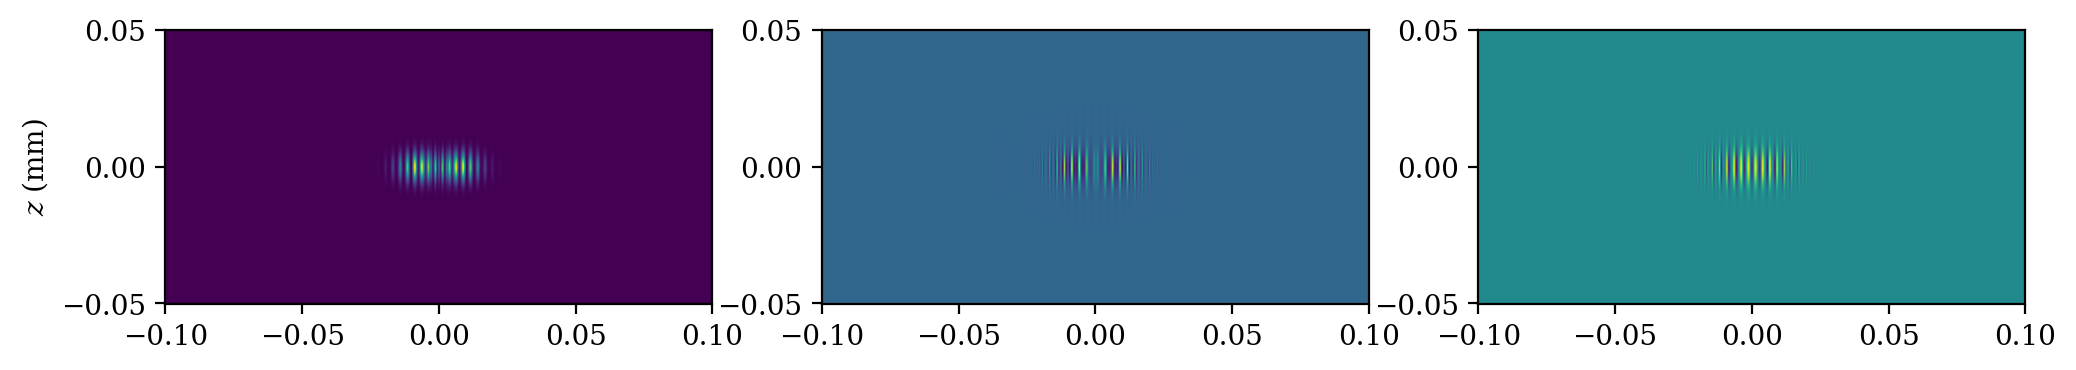

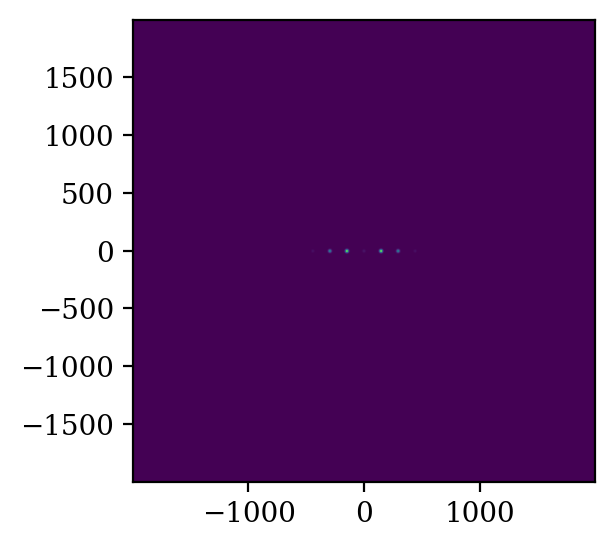

time = 175.1 µs
0.9999999999996043 |psi|^2


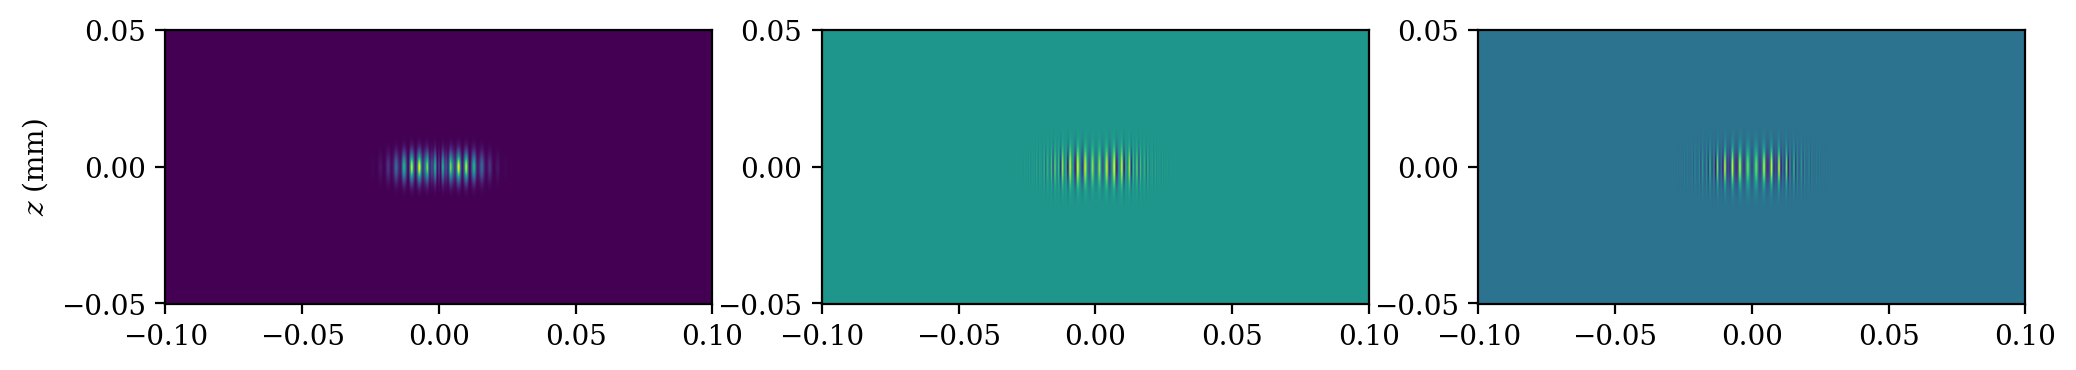

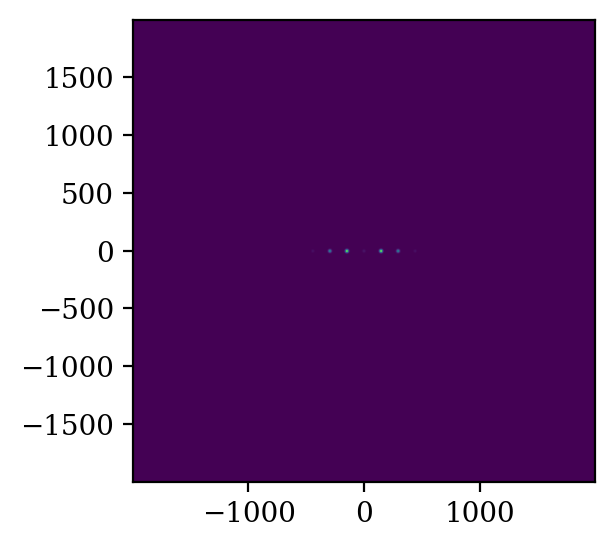

time = 195.1 µs
0.9999999999995577 |psi|^2


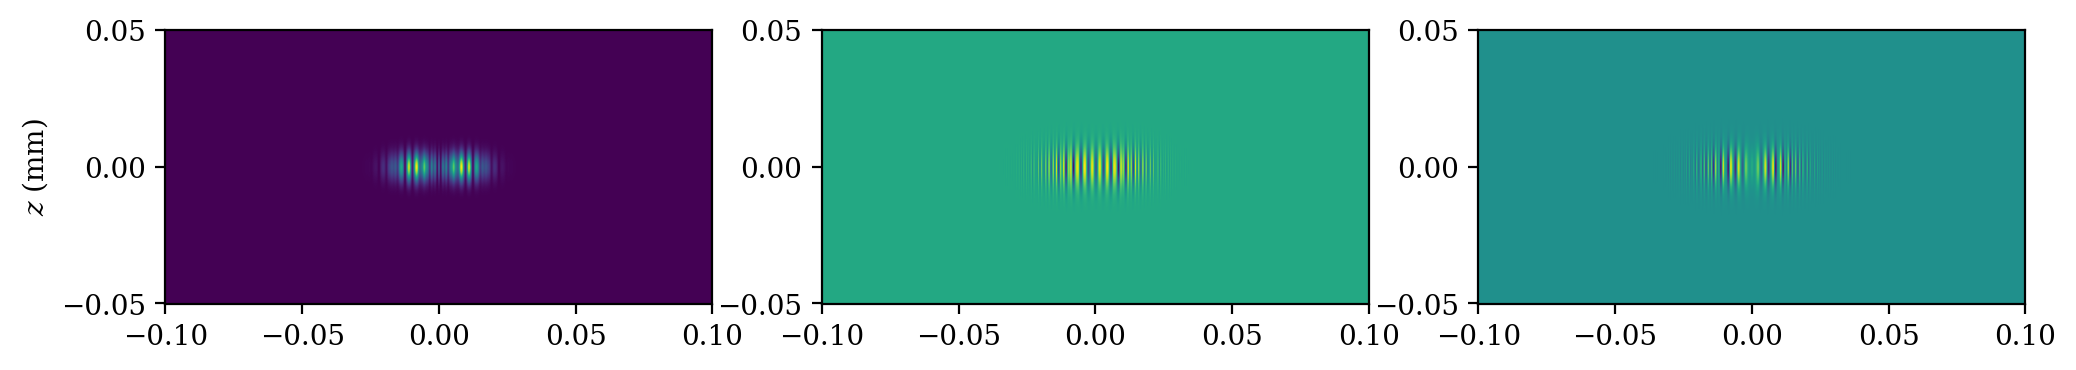

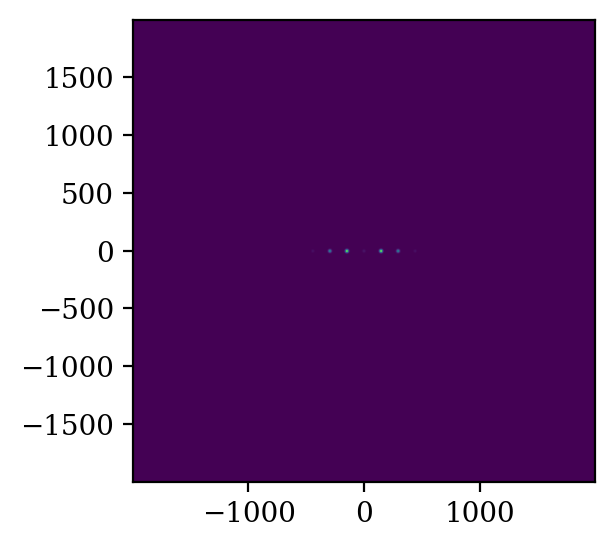

time = 215.1 µs
0.9999999999995133 |psi|^2


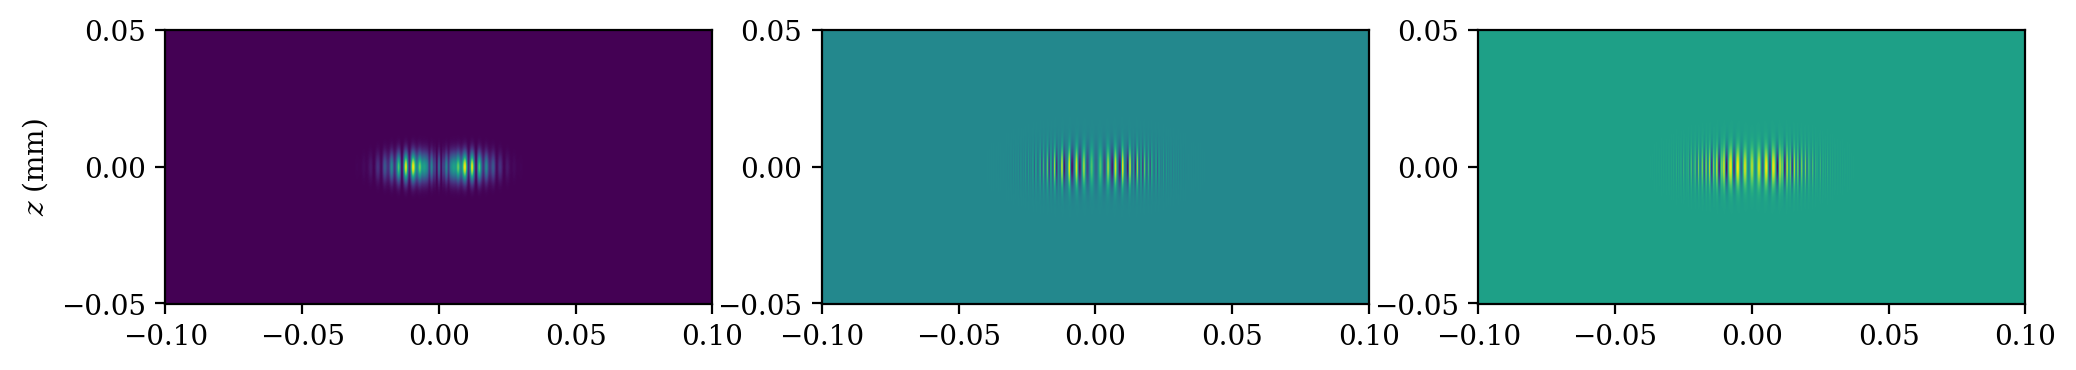

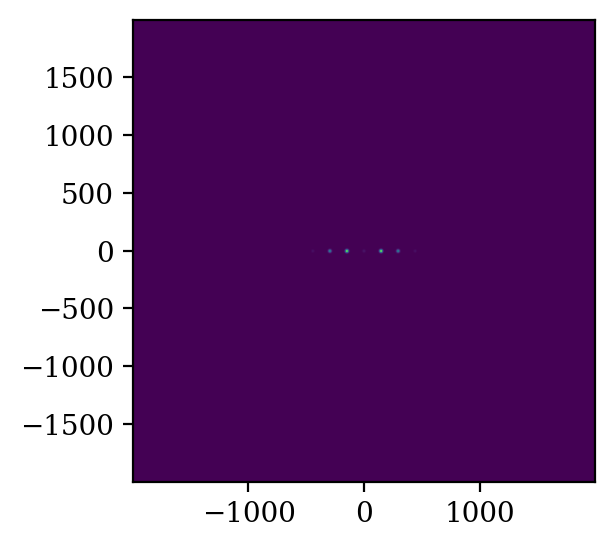

time = 235.1 µs
0.999999999999468 |psi|^2


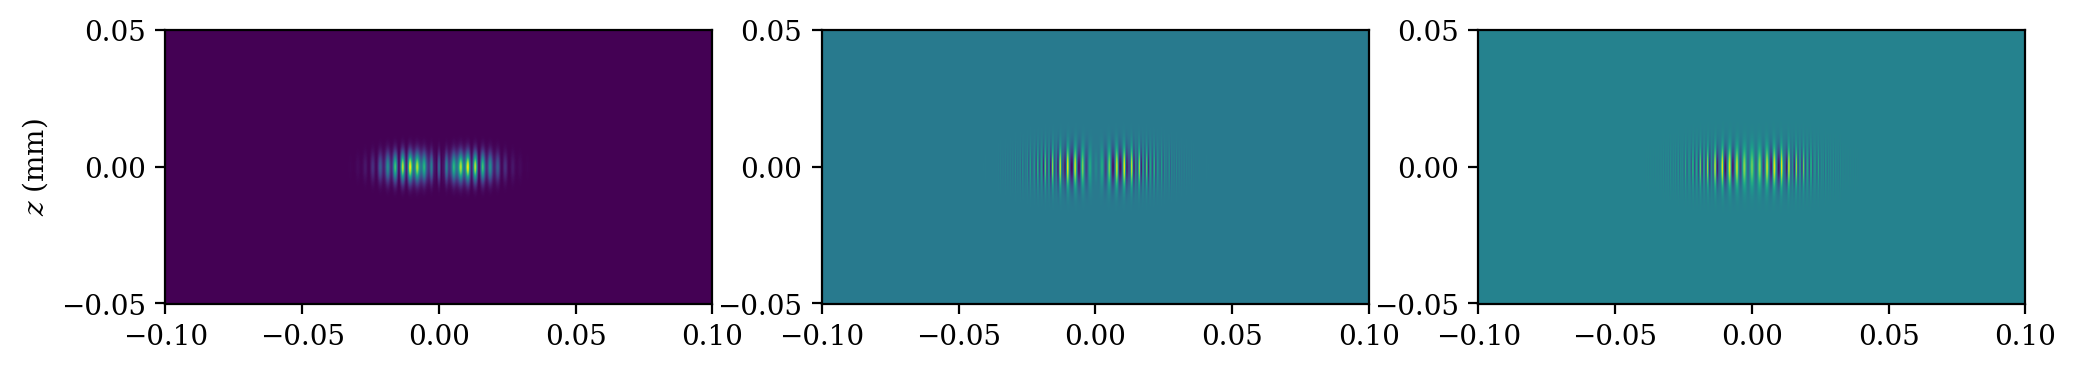

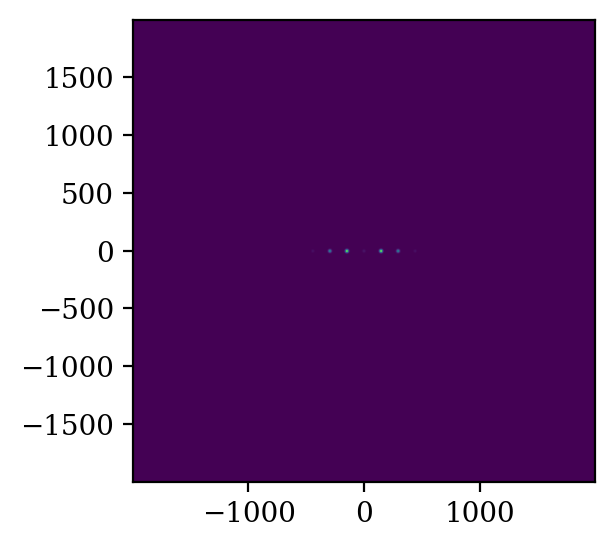

time = 255.1 µs
0.9999999999994236 |psi|^2


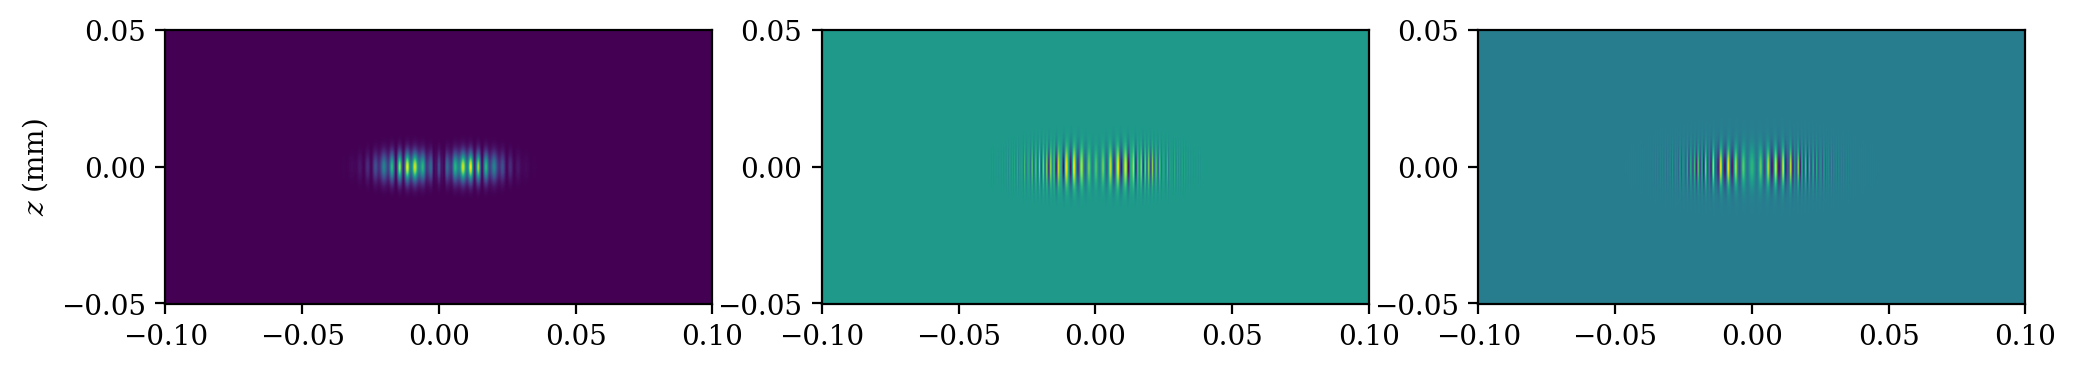

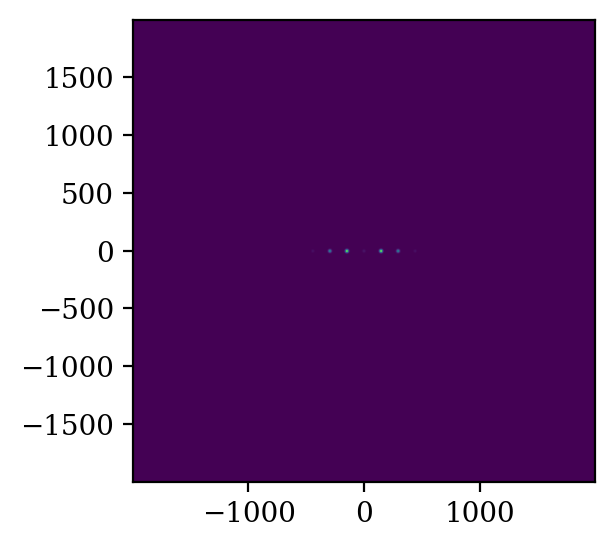

time = 275.1 µs
0.9999999999993798 |psi|^2


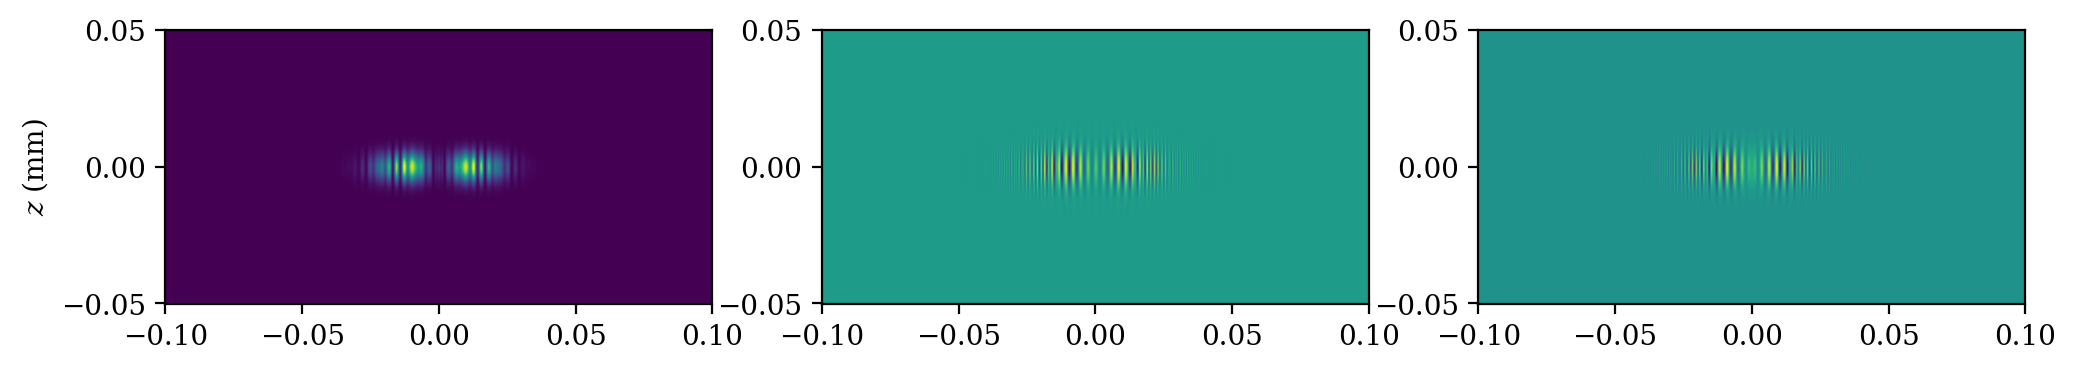

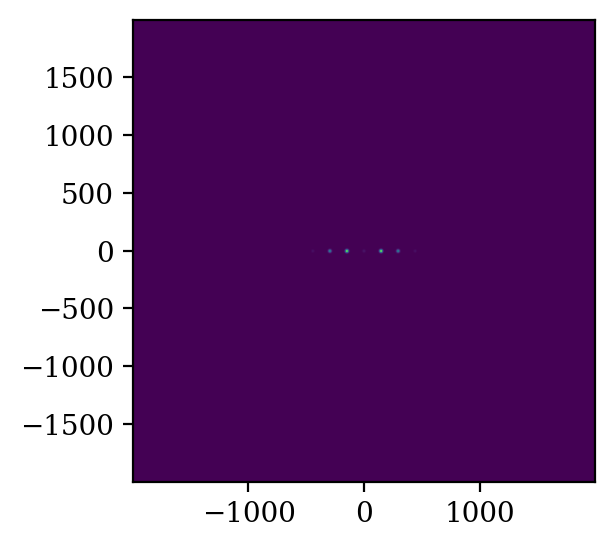

time = 295.1 µs
0.9999999999993359 |psi|^2


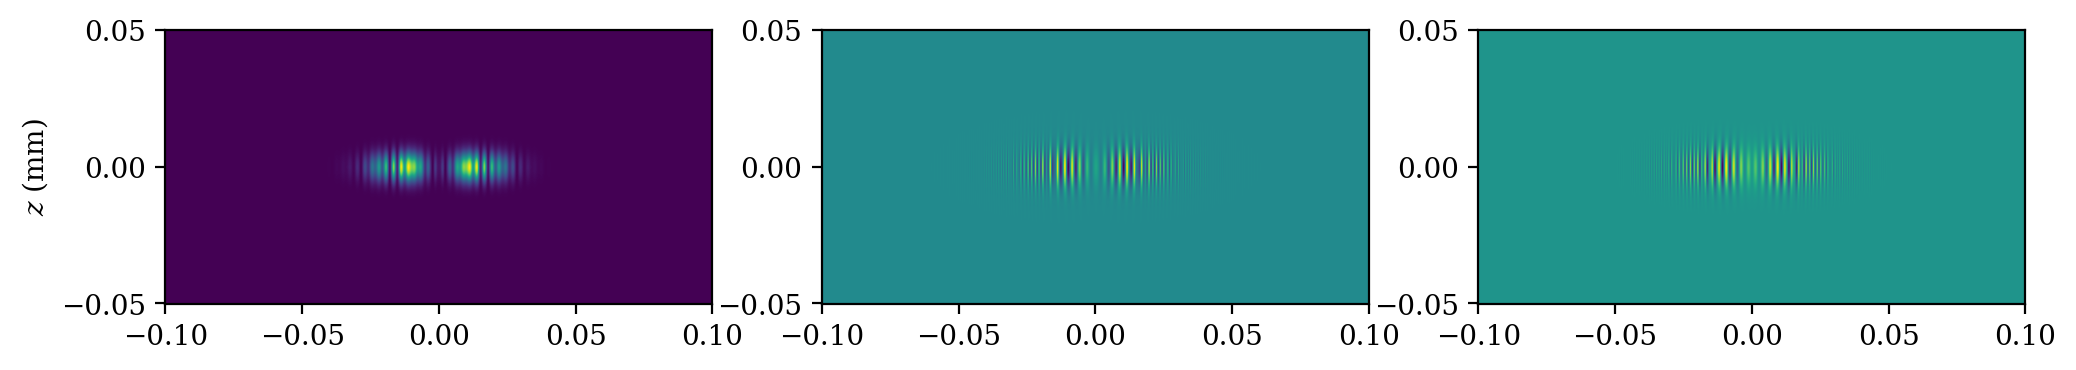

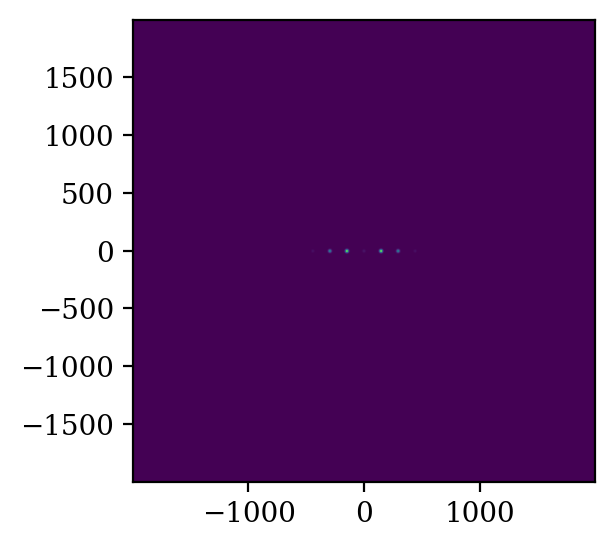

In [517]:
for step in range(3000):
#     psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(np.fft.fft2(psi)))
    phi *= expPGrid
    psi = np.fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
#     psi *= VxExpGrid
    t += dt
    if step % 200 == 0:
        print("time =", round(t*1000,4), "µs")
        print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
        plot_psi(psi)
        plot_mom(psi)

time = 315.1 µs
0.9999999999992921 |psi|^2


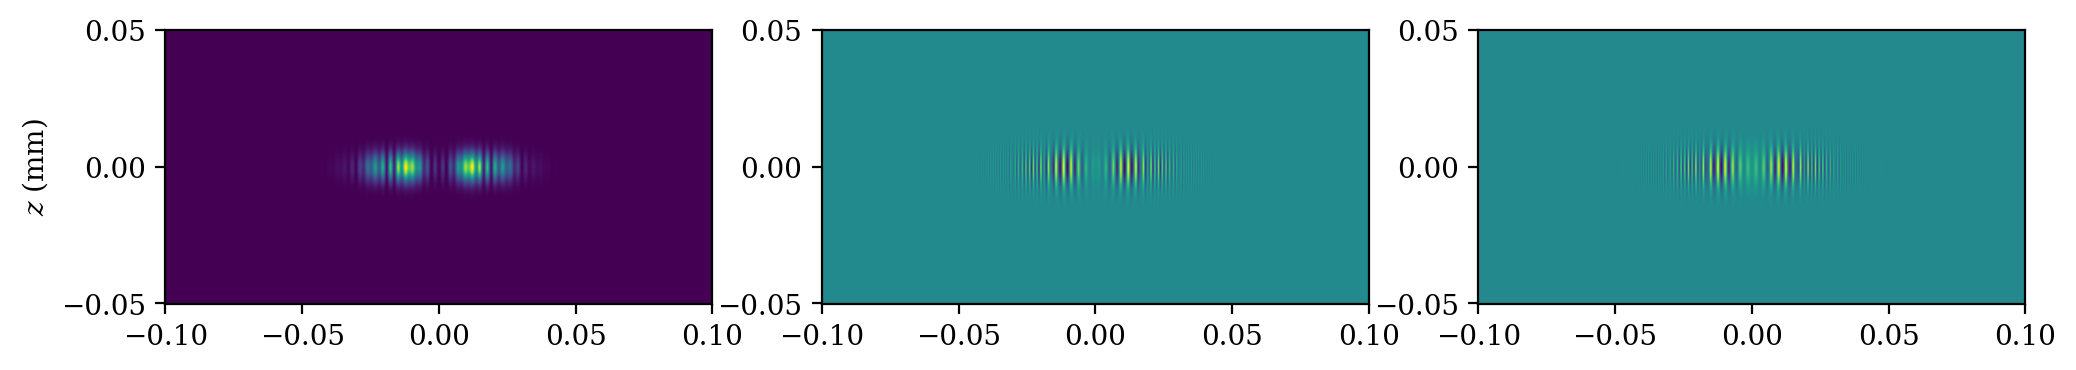

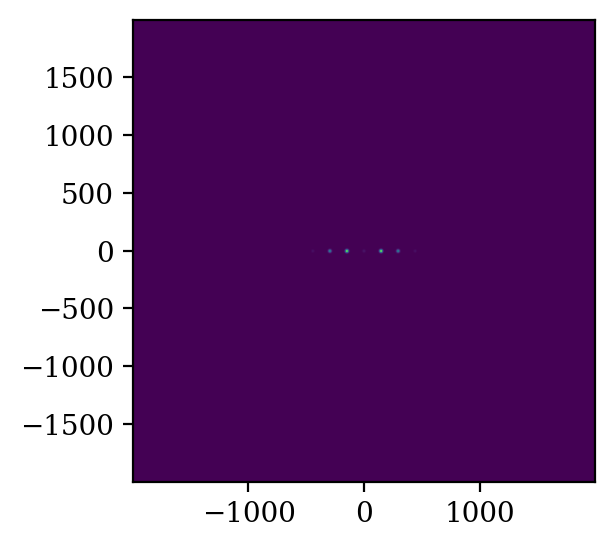

time = 365.1 µs
0.9999999999991547 |psi|^2


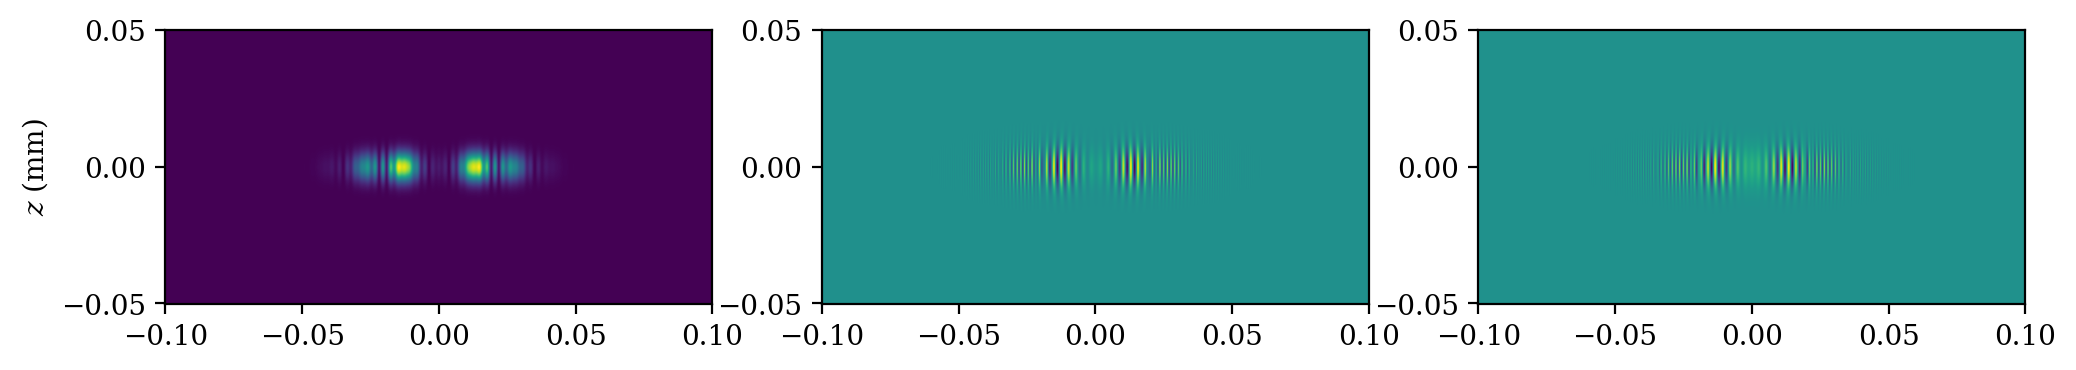

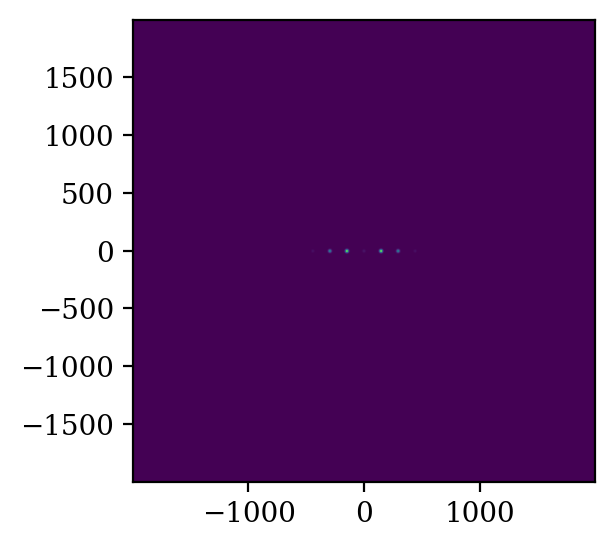

time = 415.1 µs
0.9999999999908515 |psi|^2


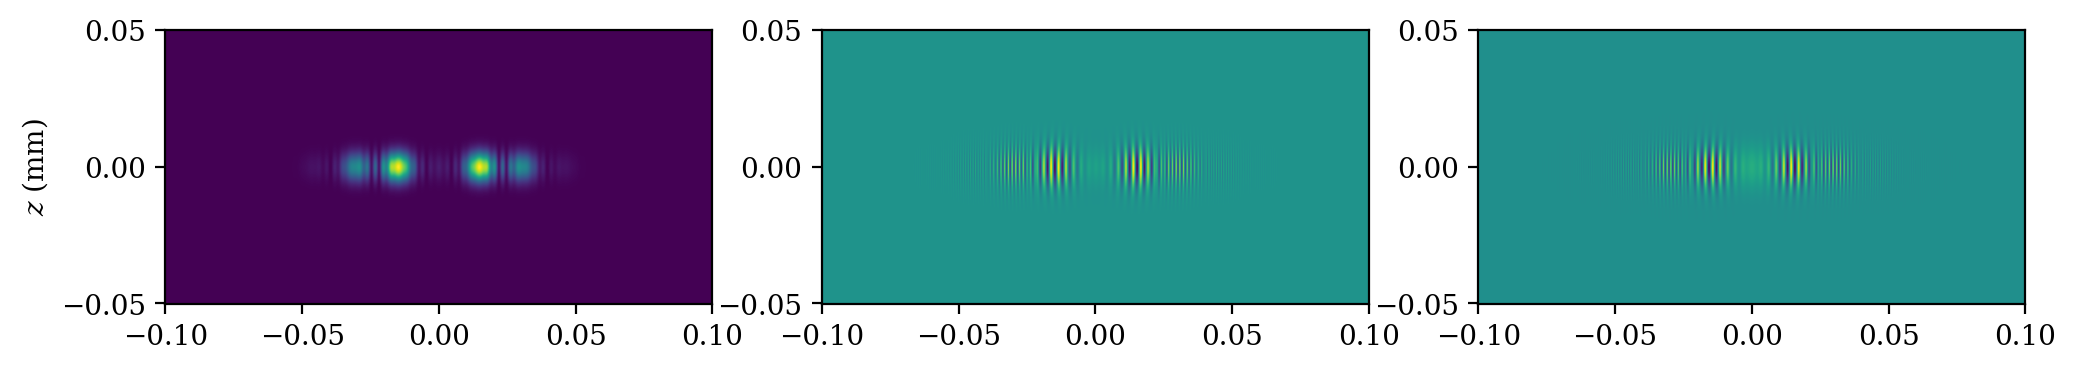

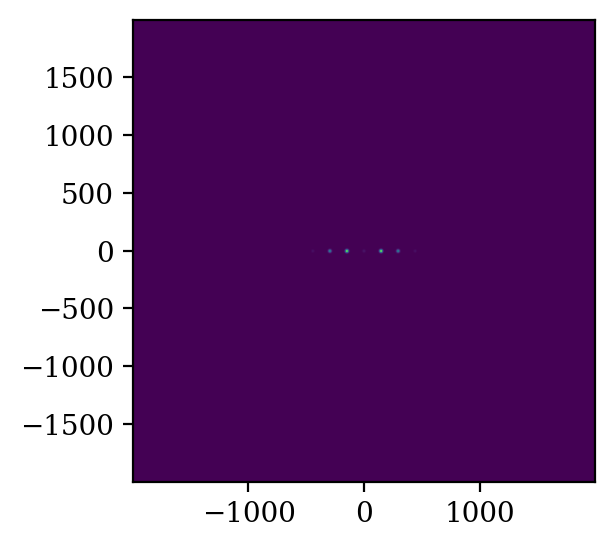

time = 465.1 µs
0.9999999997654759 |psi|^2


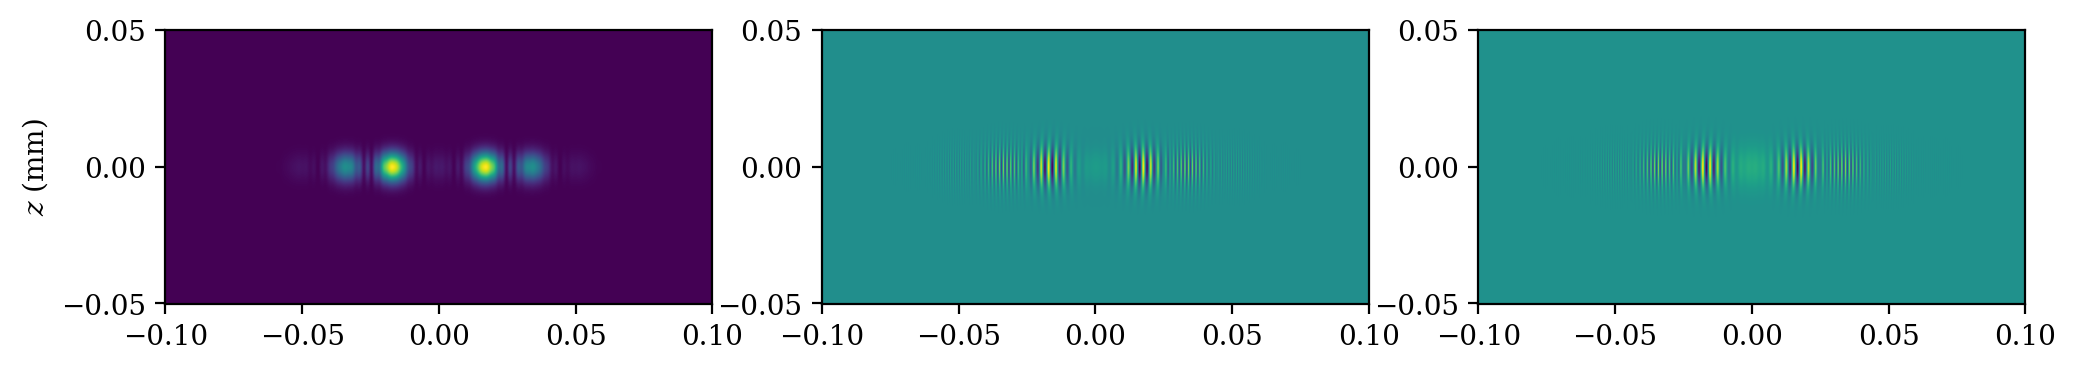

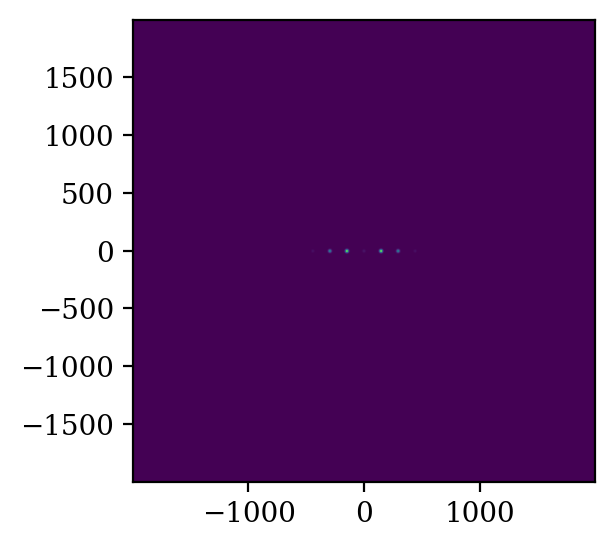

time = 515.1 µs
0.9999999798795489 |psi|^2


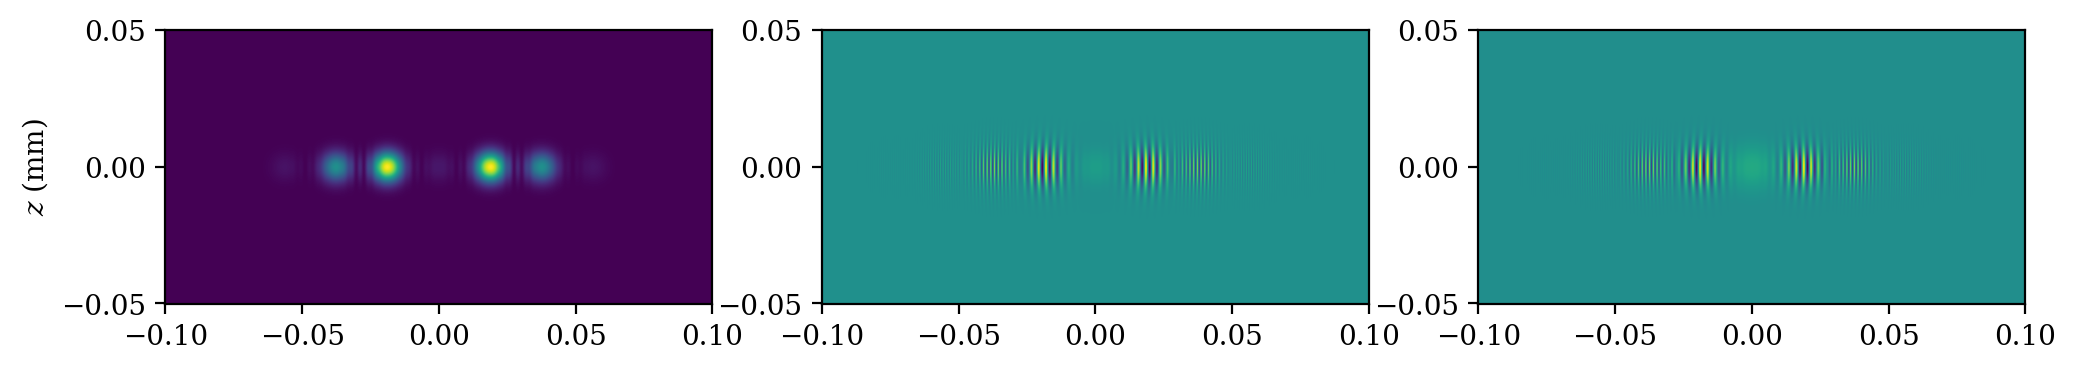

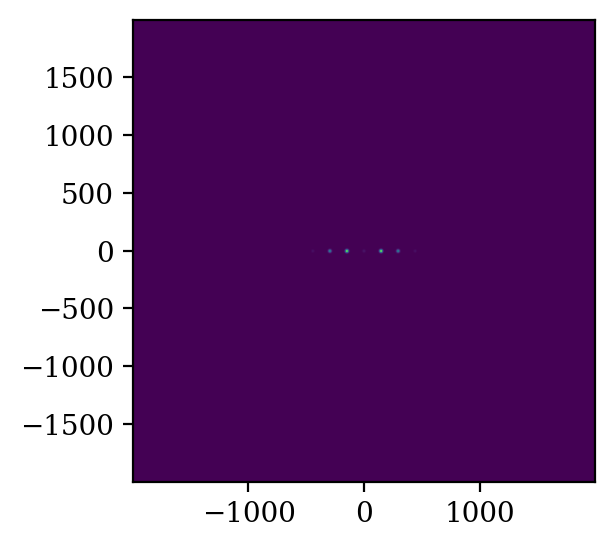

KeyboardInterrupt: 

In [518]:
for step in range(1000):
#     psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(np.fft.fft2(psi)))
    phi *= expPGrid
    psi = np.fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
#     psi *= VxExpGrid
    t += dt
    if step % 500 == 0:
        print("time =", round(t*1000,4), "µs")
        print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
        plot_psi(psi)
        plot_mom(psi)

In [522]:
#Speed test

In [527]:
for step in tqdm(range(100)):
    psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(np.fft.fft2(psi)))
    phi *= expPGrid
    psi = np.fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
    psi *= VxExpGrid
    t += dt

  0%|          | 0/100 [00:00<?, ?it/s]

In [536]:
nthreads=2
for step in tqdm(range(100)):
    psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads)))
    phi *= expPGrid
    psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi)),threads=nthreads)
    psi *= VxExpGrid
    t += dt

  0%|          | 0/100 [00:00<?, ?it/s]

In [199]:
phi.shape

(2001, 1001)

In [412]:
-(1j/hb) * (dt/2) * V00

-0.007873048664888407j

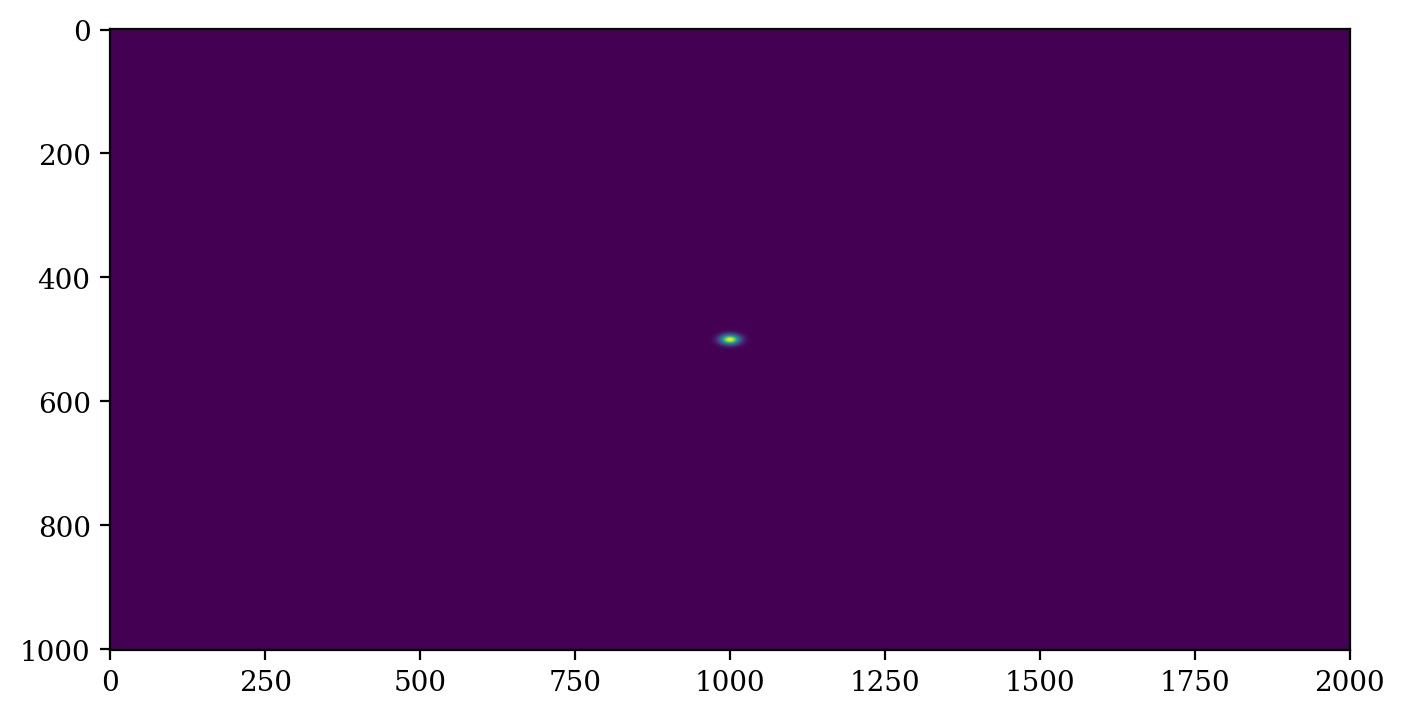

In [229]:
phi = np.fliplr(np.fft.fftshift(np.fft.fft2(psi)))
phi *= expPGrid
plt.imshow(np.abs(phi).T)

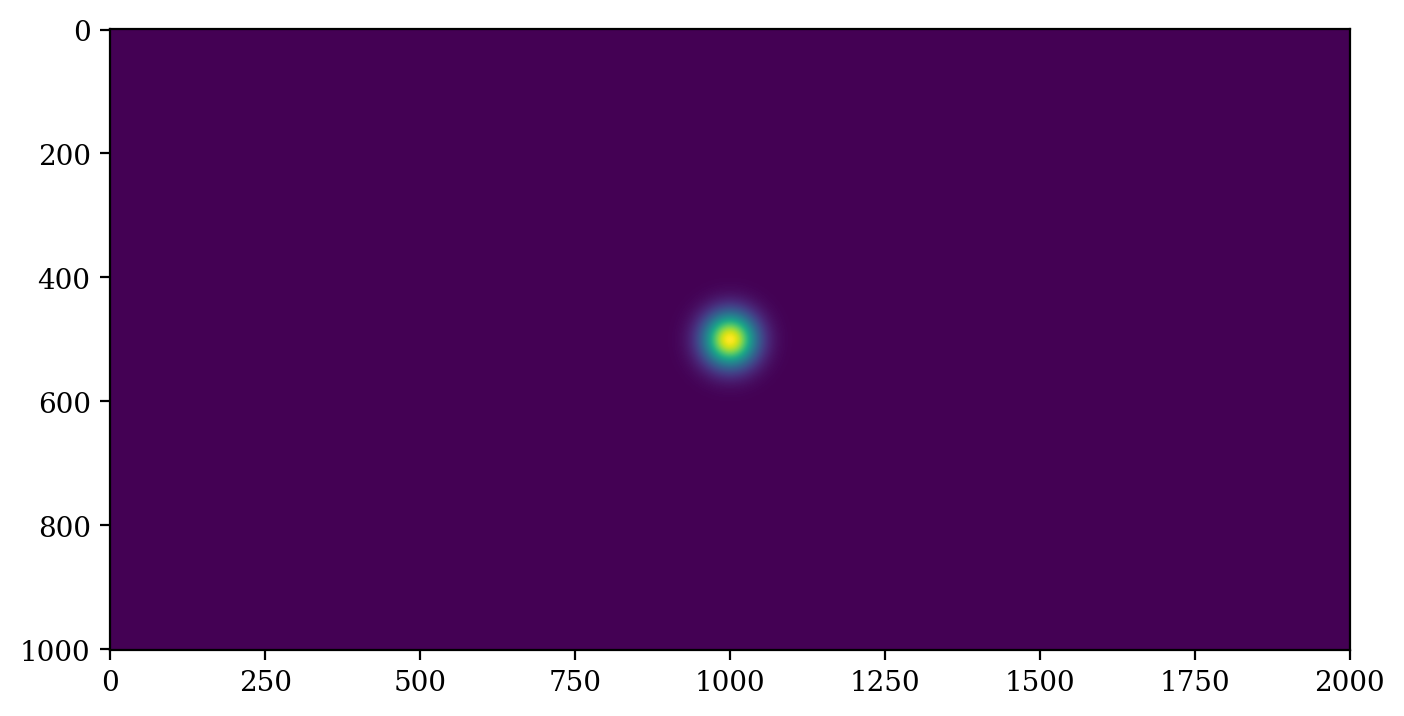

In [238]:
psiback = np.fft.ifft2(np.fft.ifftshift(np.fliplr(phi)))
plt.imshow(np.abs(psiback).T)

In [239]:
np.max(np.abs(psi-psiback))

0.003332066462743104

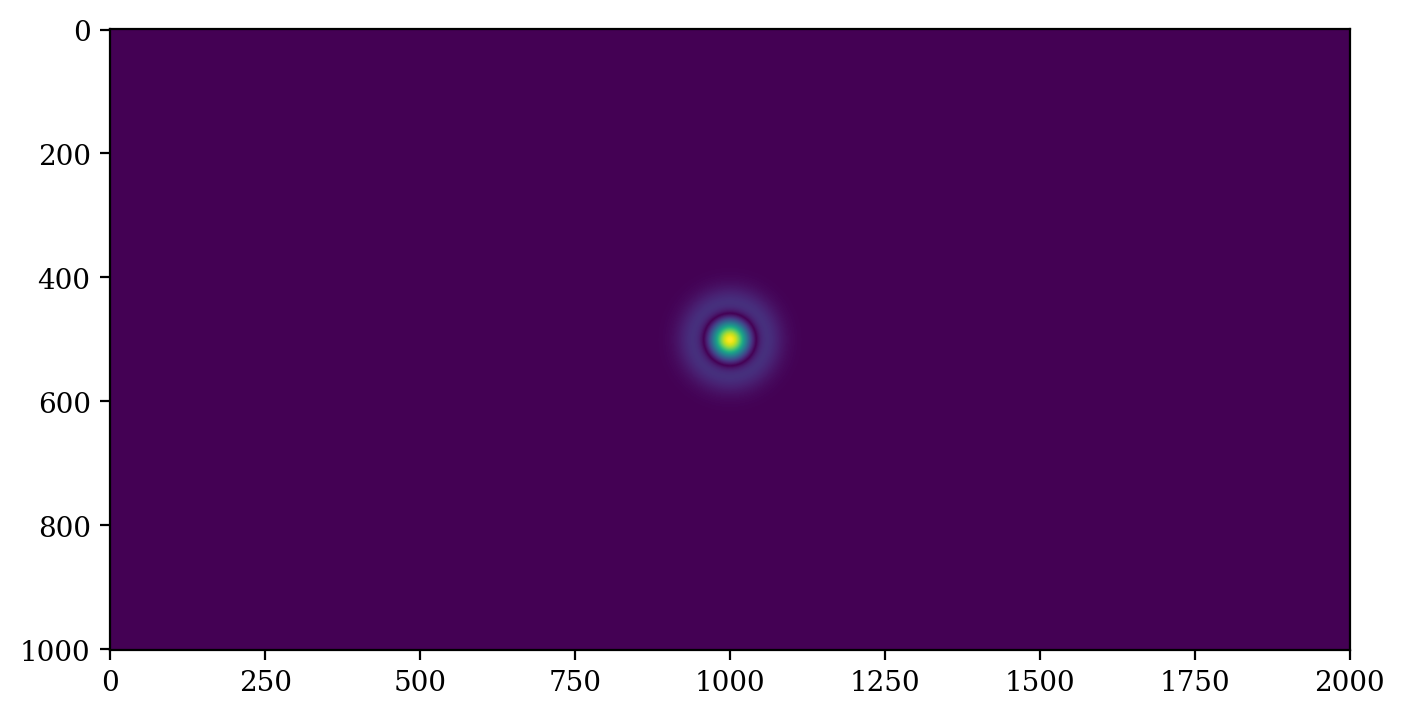

In [240]:
plt.imshow(np.abs(psi-psiback).T)

In [261]:
-(1j/hb) * (0.5/m4) * (dt)

-0.00019682621662221018j

In [283]:
np.max(np.abs(expPGrid))

1.0

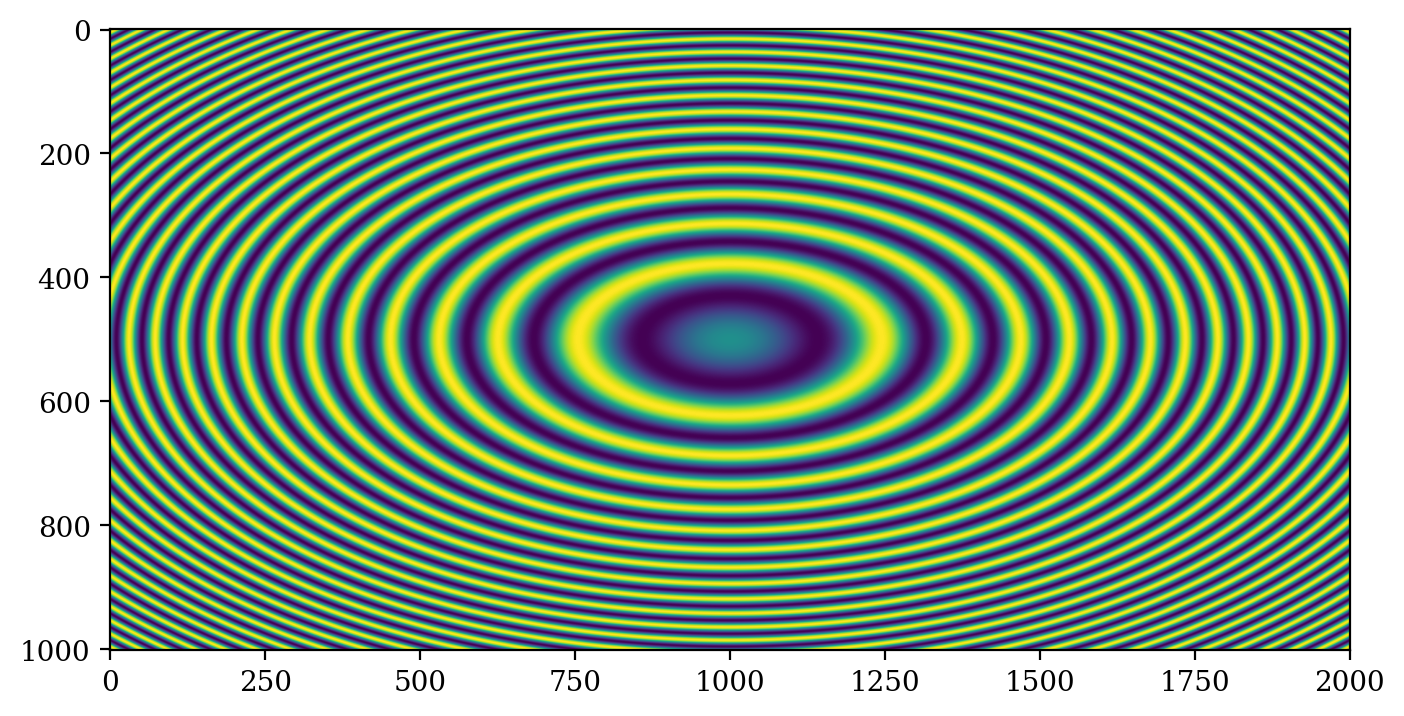

In [284]:
plt.imshow(np.imag(expPGrid).T)

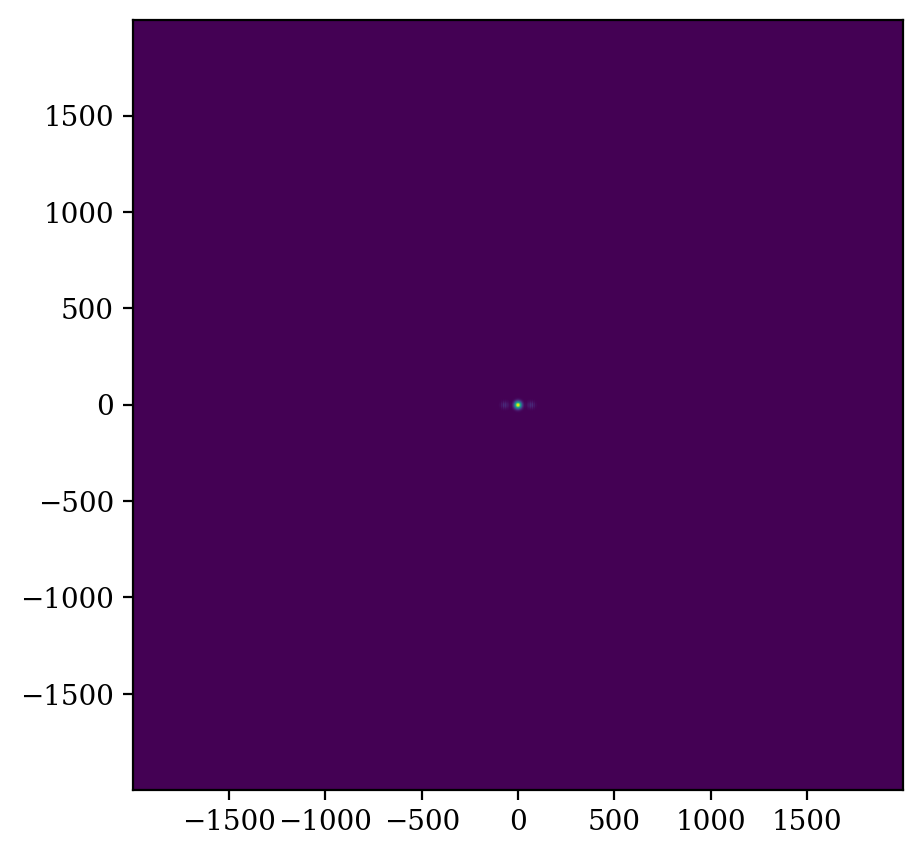

In [285]:
plt.imshow(np.abs(phi).T,extent=[-pxmax,+pxmax,-pzmax,+pzmax])

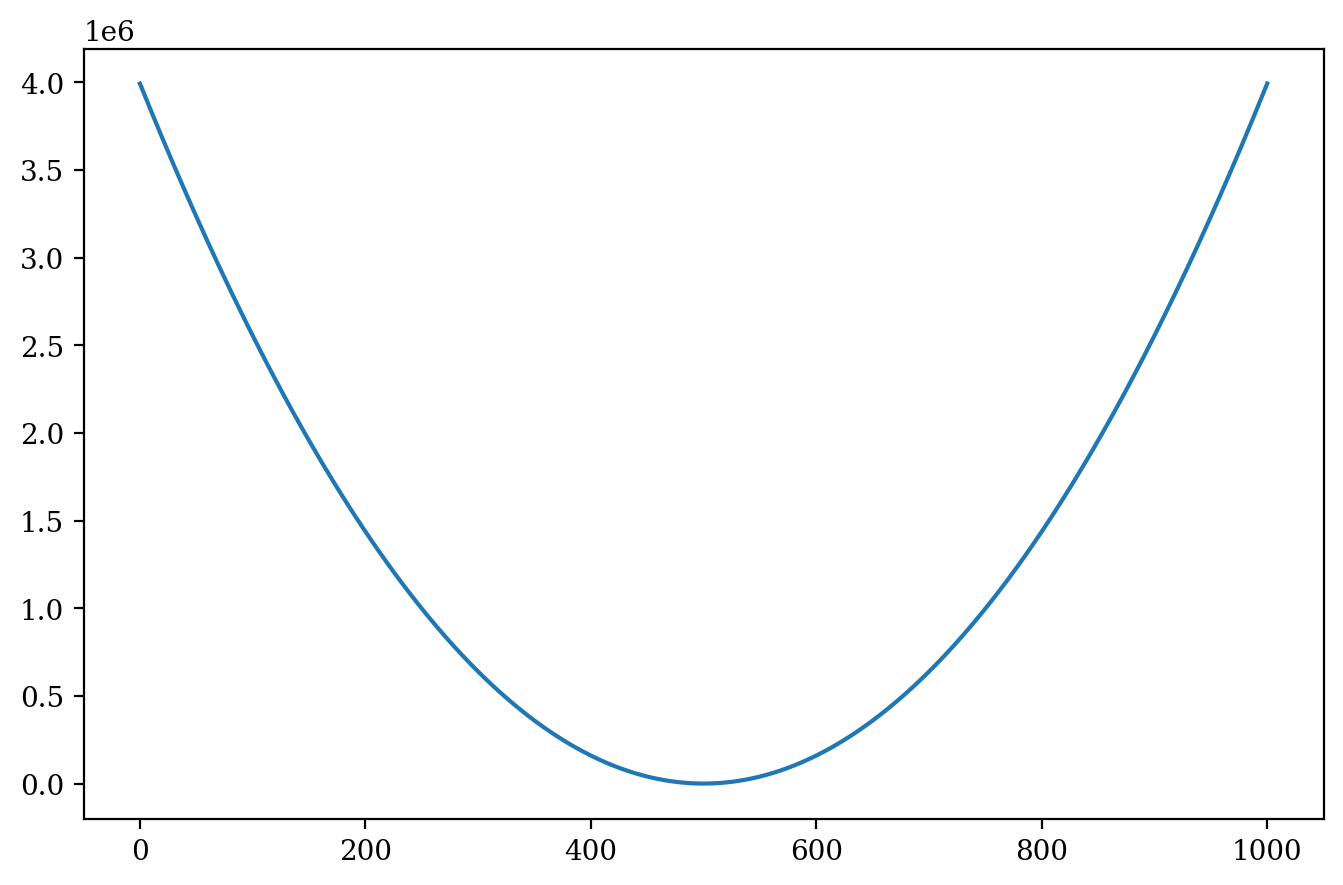

In [286]:
plt.plot(pzlin**2)

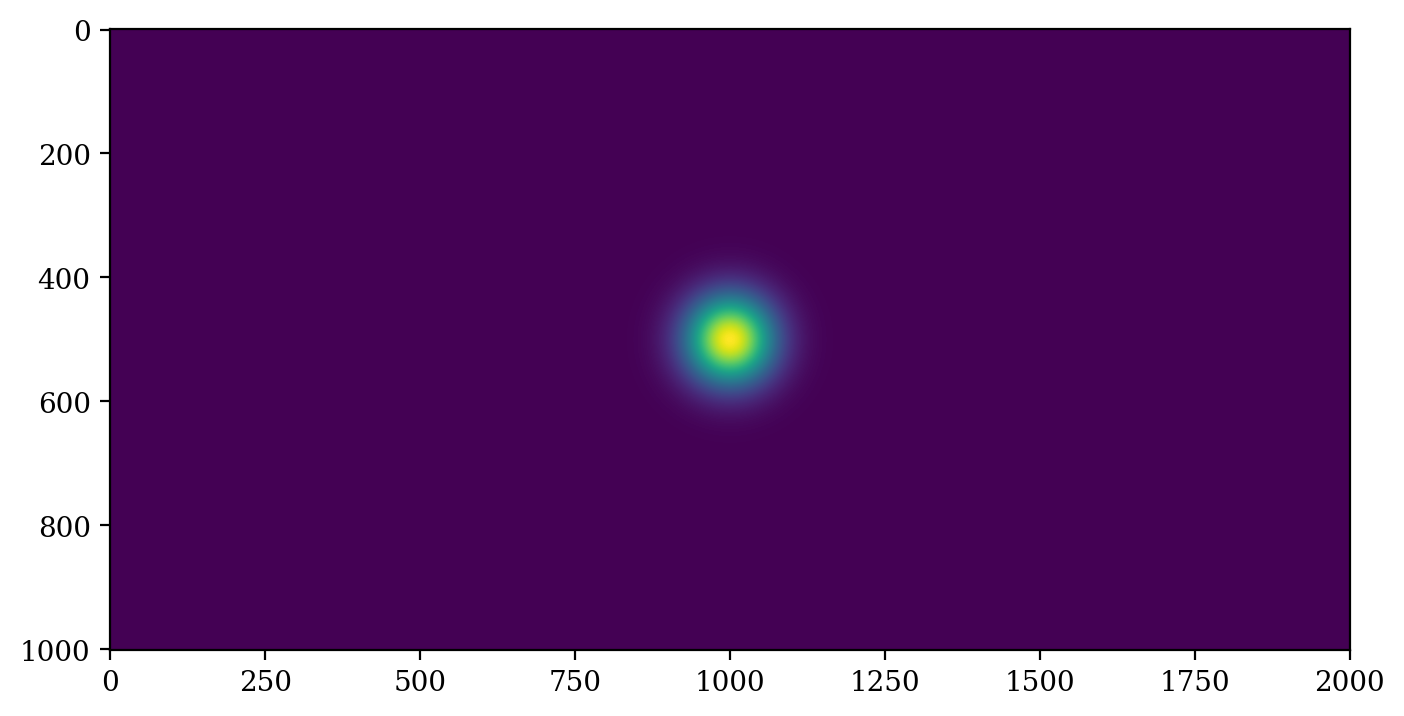

In [287]:
plt.imshow(np.abs(np.multiply(VxExpGrid, psi)).T)

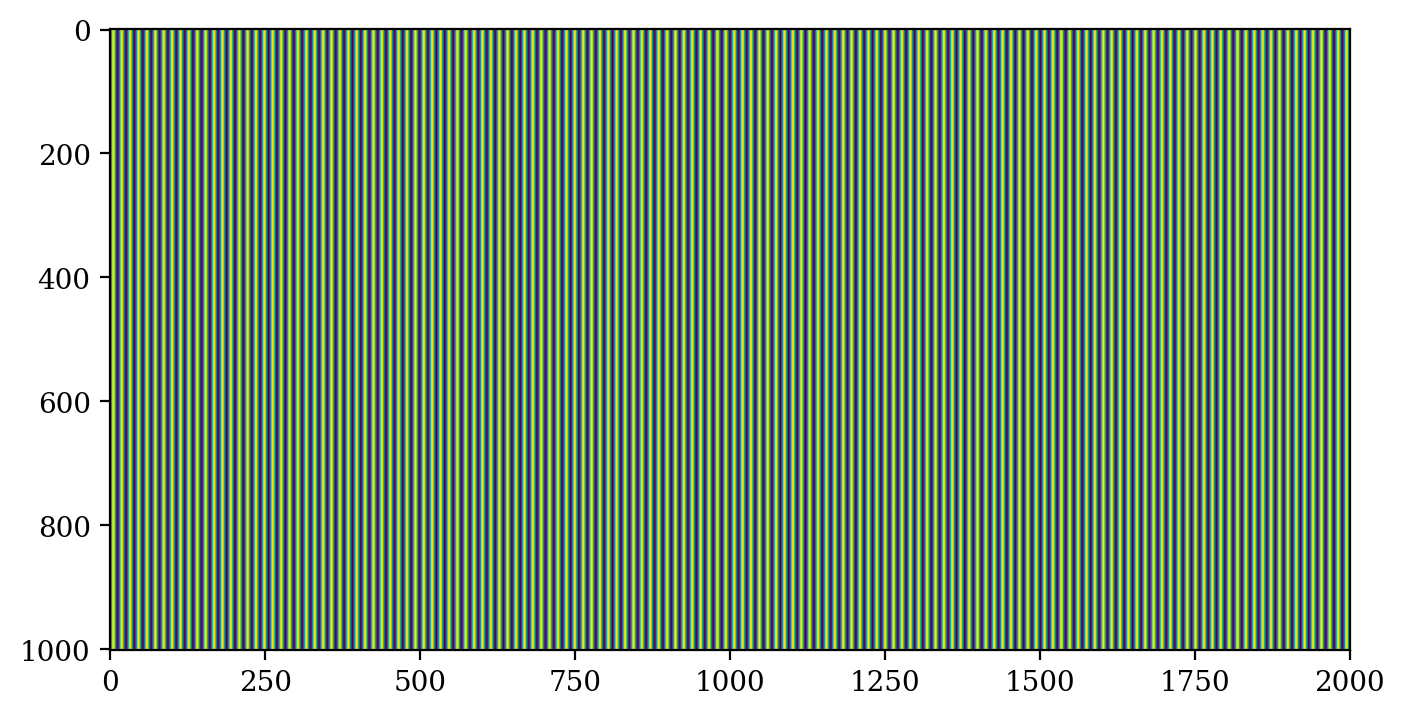

In [408]:
plt.imshow(np.real(VxExpGrid).T)

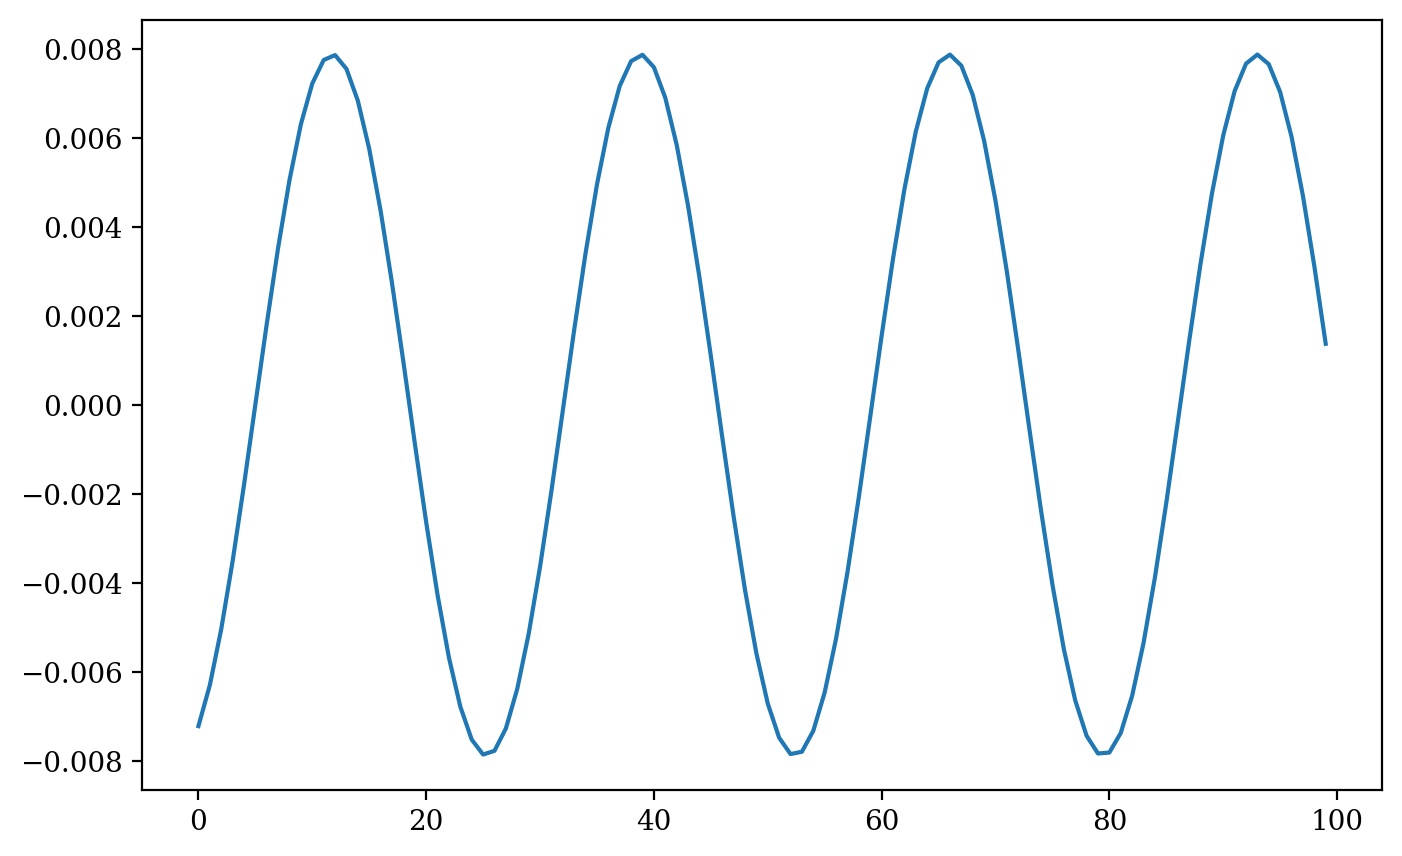

In [411]:
plt.plot(np.imag(VxExpGrid).T[0,:100])

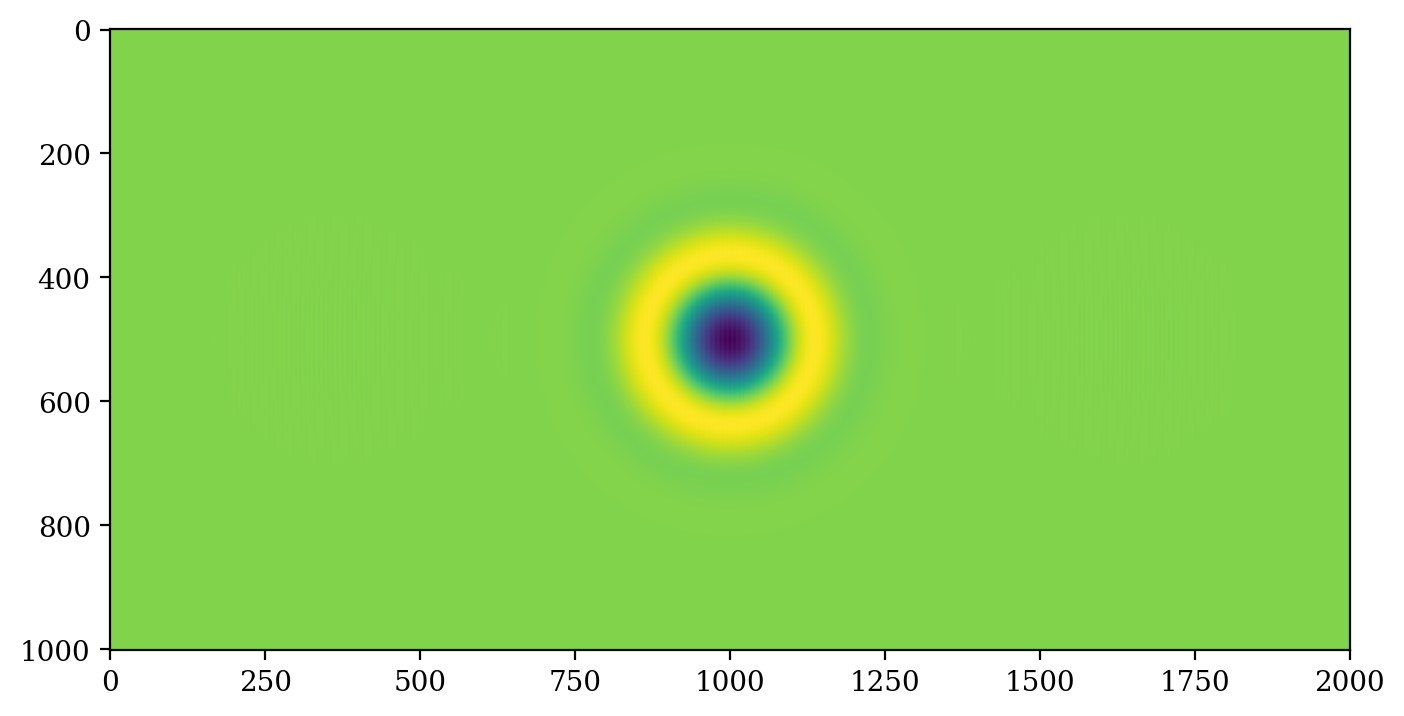

In [298]:
plt.imshow(np.imag(np.multiply(VxExpGrid, psi)).T)

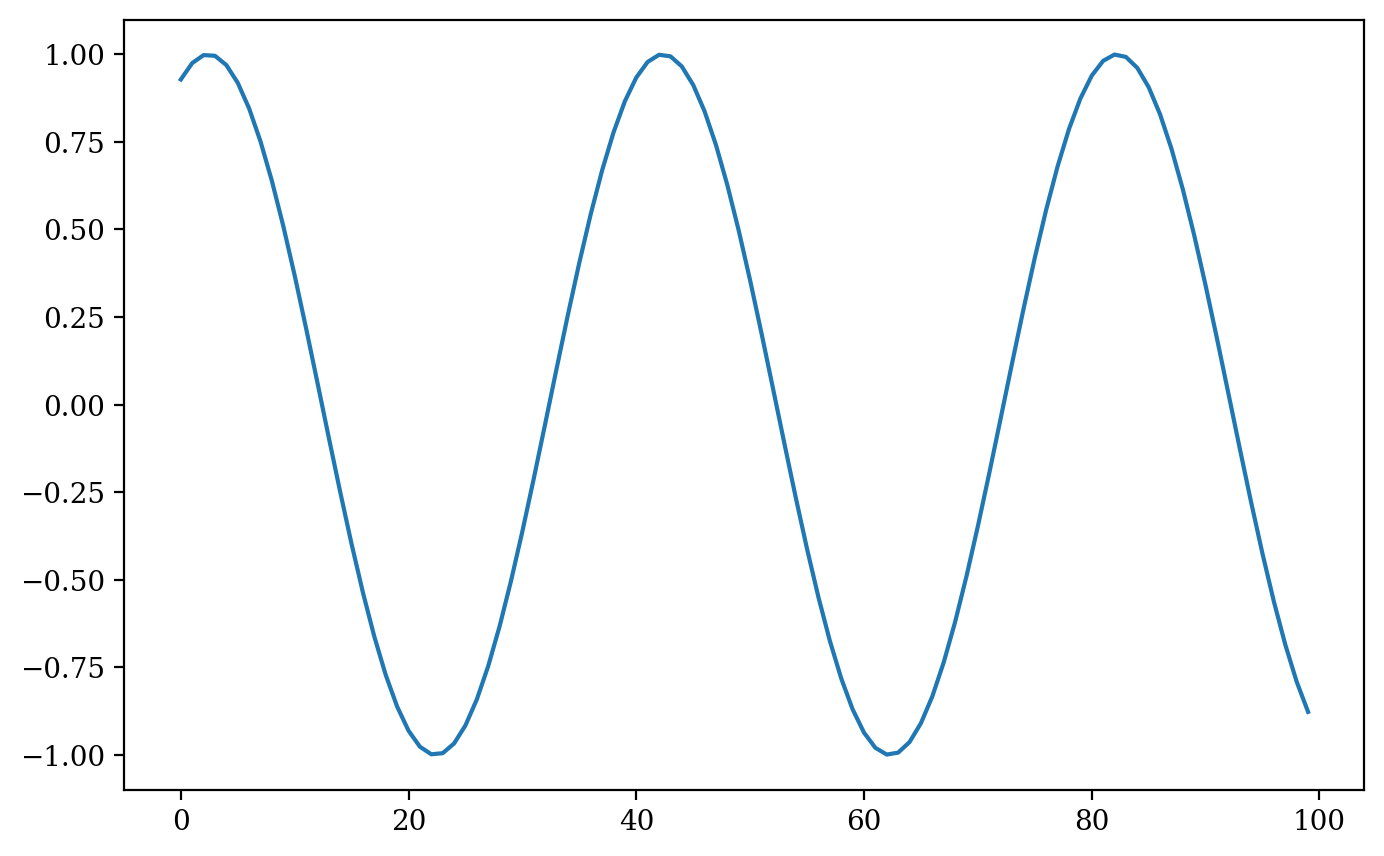

In [299]:
plt.plot(np.real(np.exp(-(1j/hb) * V00 * xgrid )).T[0,:100])

In [32]:
print(dt)
print(dt*100)
print(dt*1000)
print(dt*1000*10)
print(dt*1000*100)

1e-05
0.001
0.01
0.1
1.0


In [24]:
# @njit(parallel=True, fastmath=True)
@njit(parallel=True)
def runNB(psi,cosGrid,t,V0,tBraggCenter,tBraggPi,steps=1000): # basically so that i can run this in a different cell and keep its output
    def V(t):
#         return 30000
        if abs(t-0.5) < 0.0010: return 50000; 
        else: return 0
#         return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)
#     V = lambda t : V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)
    

    for step in range(steps):
        psi[1:-1,1:-1] += 1j*hb*dt/(2*m4*dx**2)*(\
                psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2] - 4*psi[1:-1,1:-1] )\
              - 1j*(dt/hb)*V(t)* np.multiply(cosGrid, psi[1:-1,1:-1] )
        
        if step % 10 == 0:
            psi /= np.sqrt(np.sum(np.abs(psi)**2)*dx*dz)
        t += dt 
    return (t,psi)




In [27]:
(t,psi) = runNB(psi0np(3,3,0,0),cosGrid,t,V0,tBraggCenter,tBraggPi,100) # test run (sometimes this kills the kernel? don't know why)

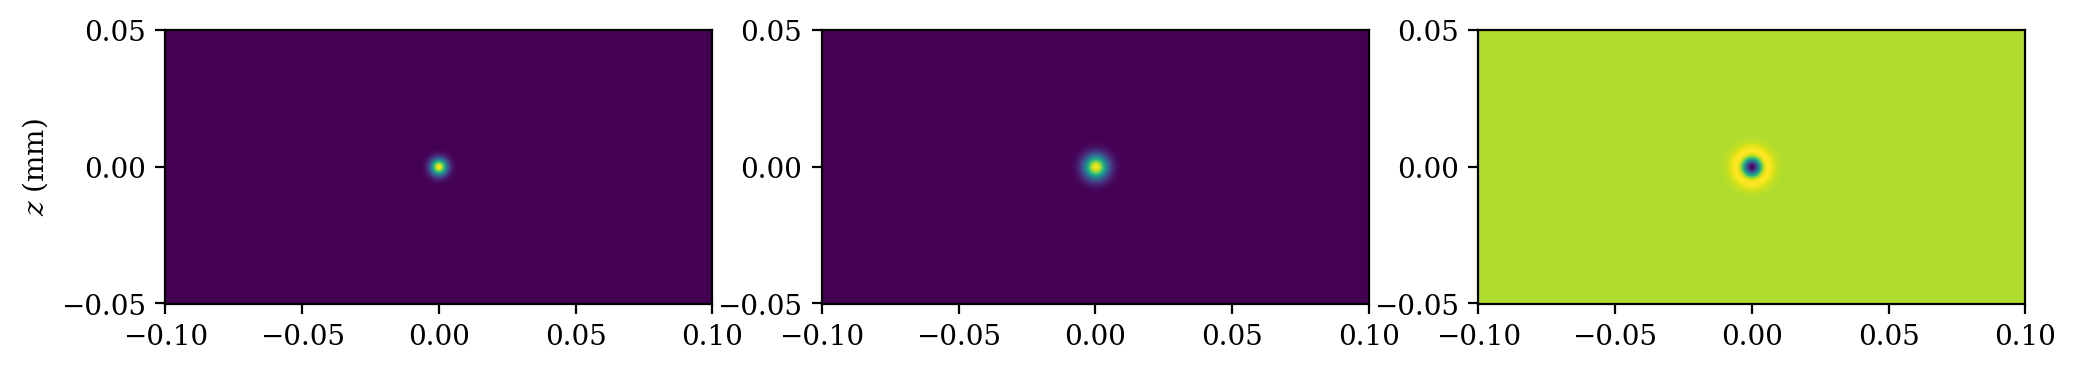

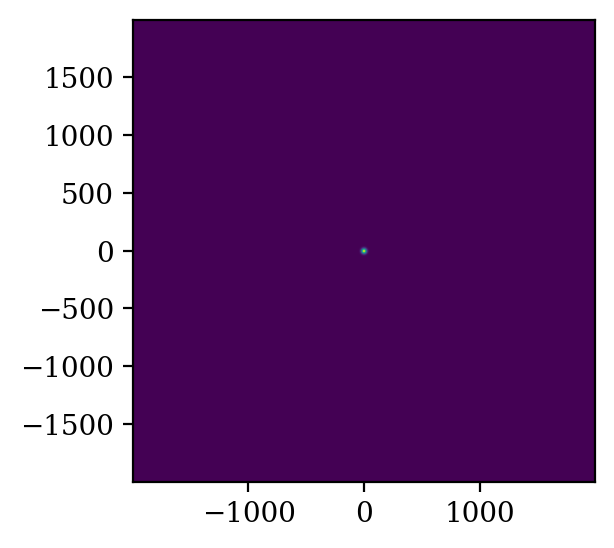

In [28]:
plot_psi(psi)
plot_mom(psi)

In [68]:
def runNBWithPlots(psi=psi,t=0,endTMs=10, plotEveryMs=0.1):
    if t >= endTMs: return (t,psi)
    iterCount = int((endTMs-t) / plotEveryMs)
    print("Initial state at t =", round(t,4), "ms", "Target end time at ", round(endTMs,4), "ms")
    plot_psi(psi)
    plot_mom(psi)
    
    for step in tqdm(range(iterCount)):
        (t,psi) = runNB(psi,cosGrid,t,V0,tBraggCenter,tBraggPi,int(plotEveryMs/dt))
        print("time =", round(t,4), "ms")
        print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
        plot_psi(psi)
        plot_mom(psi)
    return (t,psi)

In [69]:
# (t,psi) = runNBWithPlots(psi0np(30,30,0,0),0,1,0.2)

Initial state at t = 0 ms Target end time at  5 ms


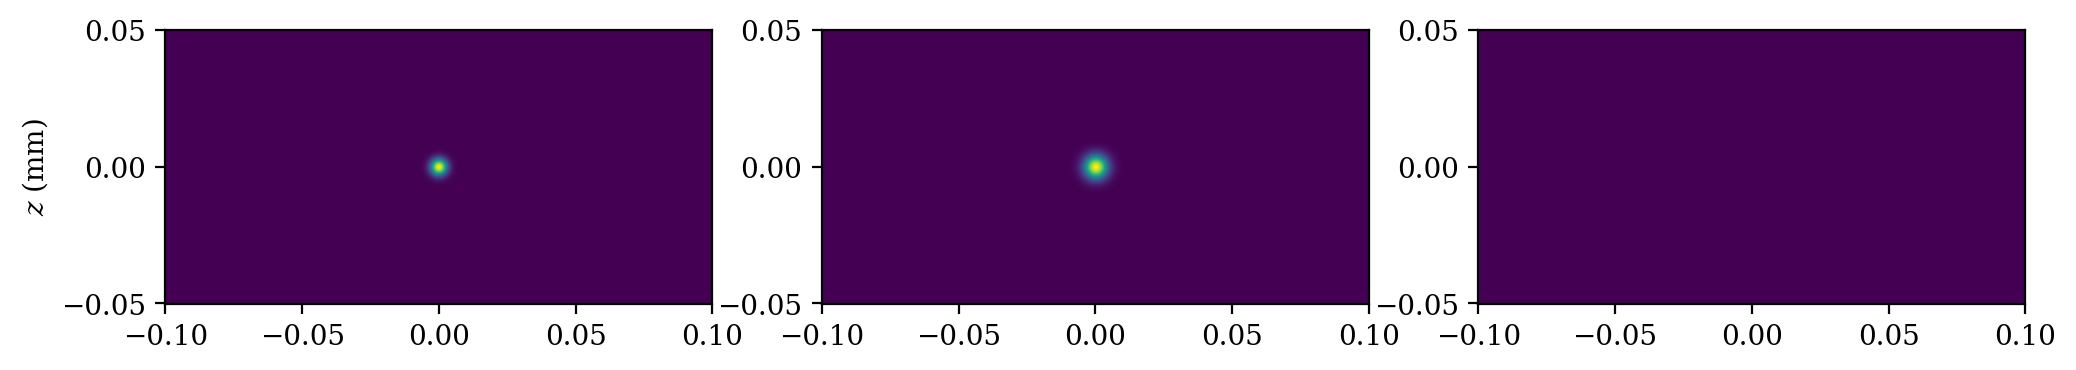

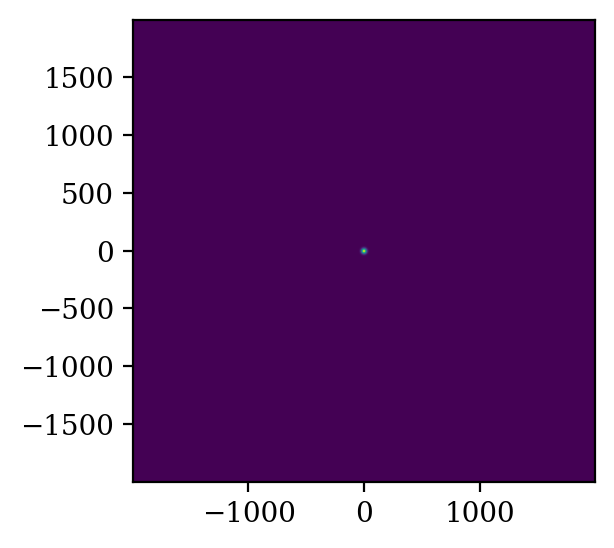

  0%|          | 0/500 [00:00<?, ?it/s]

time = 0.01 ms
1.0000000012455947 |psi|^2


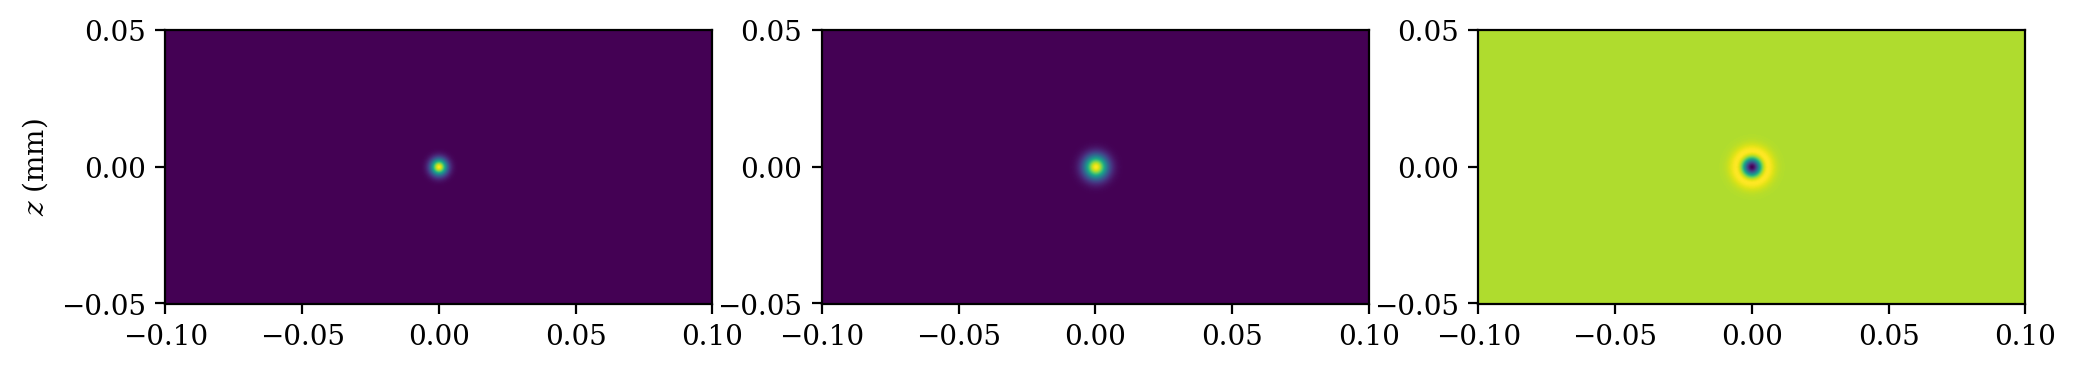

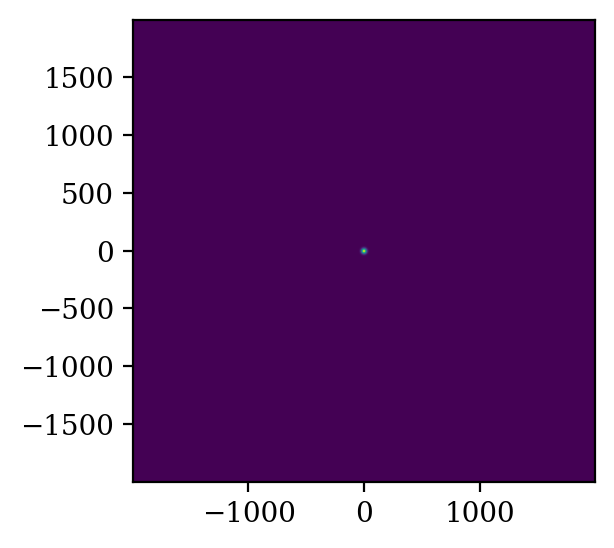

time = 0.02 ms
1.0000000012455923 |psi|^2


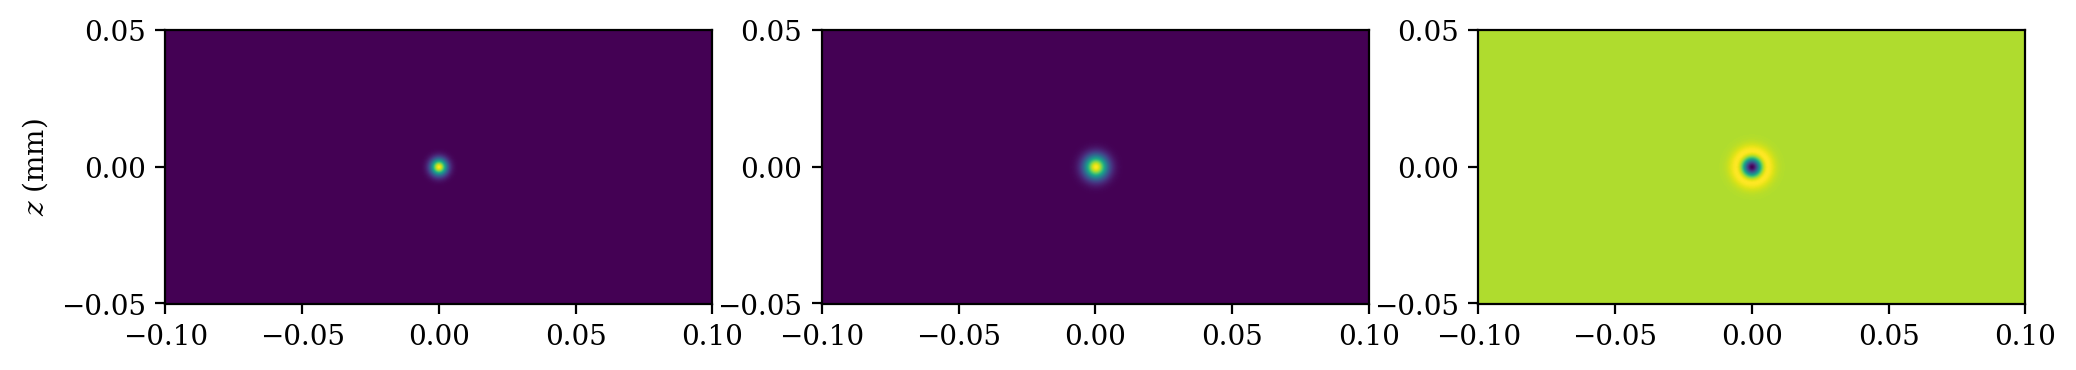

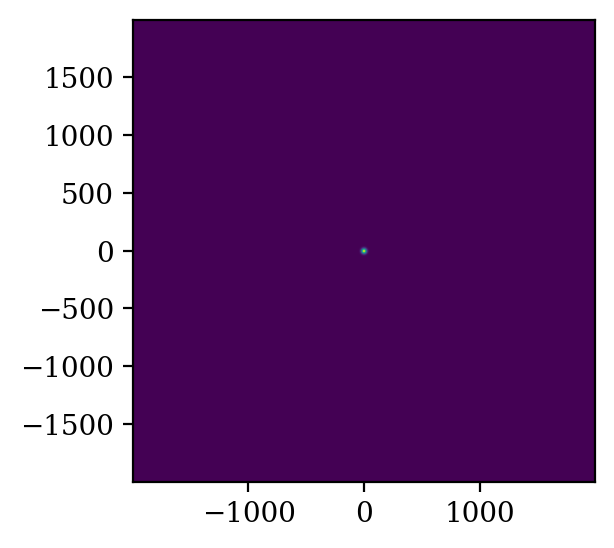

time = 0.03 ms
1.0000000012455819 |psi|^2


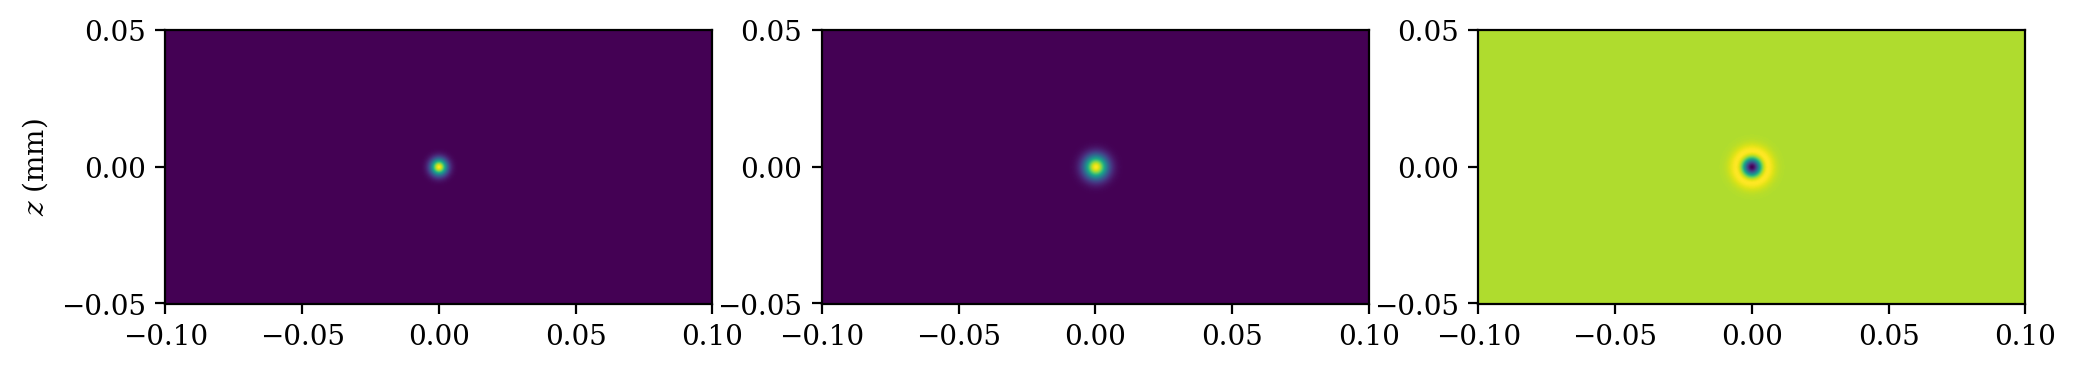

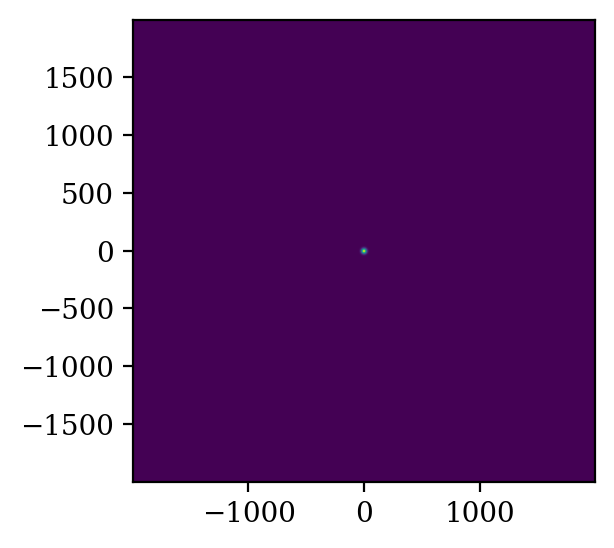

In [ ]:
(t,psi) = runNBWithPlots(psi0np(3,3,0,0),0,5,0.01)

In [ ]:
(t,psi) = runNBWithPlots(psi,t,20,0.05)

In [ ]:
t